In [2]:
# ! git clone https://github.com/BlackkkMaster/ad_project_team16
# %cd ad_project_team16

# Анализ спроса на самокаты

Для повышения прибыльности проекта руководство компании хочет внедрить динамическую систему определения стоимости поездки.

В данной тетрадке проводится анализ имеющихся данных и поиск определяющих объем спроса факторов, на которые необходимо обратить внимание при формировании такой системы.

Исследование состоит из следующих шагов:

- Предобработка данных (EDA)
- Расчётные задачи
- Проверка гипотез
- Построение регрессионной модели

## Содзадние и настрйока нужных функций и импортов

### Импорты

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import datetime as dt

### Функции

In [4]:
def pass_value_barh(df, df_tittle):
    try:
        (
            (df.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: "space"})
            .query("space > 0")
            .sort_values(by="space", ascending=True)
            .plot(kind="barh", figsize=(10, 5), rot=0, legend=False, fontsize=12)
            .set_title(
                f'Доля пропусков в столбцах датафрейма "{df_tittle}" (%)' + "\n",
                fontsize=16,
                color="SteelBlue",
            )
        )
    except:
        print("Пропусков нет")


def streets_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"ул\.?\s?", value="")
    return tdf


def rayons_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"\s", value="-")
    return tdf

# Функция для проверки на нормальность:
def test_stapiro(_df, _column, _pv=0.05):

    _stat, _p_value = st.shapiro(_df[_column])

    print(f"shapiro-Wilk Test Statistic для '{_column}': {_stat:.4f}")
    print(f"shapiro-Wilk P-value для '{_column}': {_p_value:.4f}")
    print(
        f"Расспределение '{_column}': {'Не нормальное распределение' if _p_value < _pv else 'Нормальное распределение'}\n"
    )


def cat_graph(df, cat_feat, tittle):
    params = {
        "axes.labelsize": 12,
        "figure.titlesize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
    plt.rcParams.update(params)

    colors = sns.color_palette("pastel")[0:10]

    cols = 2
    num_features = len(cat_feat)
    rows = int(np.ceil(num_features / cols)) if num_features > 0 else 1

    fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))

    axs_flat = axs.flatten()

    for count, col in enumerate(cat_feat):
        if count >= len(axs_flat):
            break

        ax = axs_flat[count]

        df1 = pd.DataFrame(df.groupby([col])[col].count())
        ax.pie(
            x=df1[col],
            colors=colors,
            labels=df1.index,
            autopct="%1.1f%%",
            textprops={"fontsize": 10},
        )
        ax.title.set_text(str(col))

    for k in range(num_features, len(axs_flat)):
        fig.delaxes(axs_flat[k])

    plt.suptitle(f"Круговые диаграммы категориальных признаков {tittle}", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


def calculate_cost_per_minute(row):
    day_of_week = row["day_of_week"]
    group_of_time = row["group_of_time"]

    if 1 <= day_of_week <= 5:  # Будние дни
        if group_of_time == 1:
            return 3
        elif group_of_time == 2:
            return 4
        elif group_of_time == 3:
            return 5
        elif group_of_time == 4:
            return 6
        elif group_of_time == 5:
            return 5
    elif 6 <= day_of_week <= 7:  # Выходные
        if group_of_time == 1:
            return 3
        elif group_of_time == 2:
            return 4
        elif group_of_time == 3:
            return 6
        elif group_of_time == 4:
            return 7
        elif group_of_time == 5:
            return 6
    return 0


def plot_comparison_histograms(
    df1, df2, columns, df1_title="DataFrame 1", df2_title="DataFrame 2"
):
    rows = len(columns)
    if rows == 0:
        print("нет количественных данных")
        return

    fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    fig.tight_layout(pad=3.0)
    plt.rcParams.update({"font.size": 12})

    for i, col in enumerate(columns):
        sns.histplot(df1[col], kde=True, bins=15, ax=axs[i][0])
        axs[i][0].set_title(f"{col} в {df1_title}")
        axs[i][0].set_xlabel(col)
        axs[i][0].set_ylabel("Значение")

        sns.histplot(df2[col], kde=True, bins=15, ax=axs[i][1])
        axs[i][1].set_title(f"{col} в {df2_title}")
        axs[i][1].set_xlabel(col)
        axs[i][1].set_ylabel("Значение")

    plt.suptitle(f"Сравнение колонок в датасетах", fontsize=16, y=1.02)
    plt.show()


def find_most_similar_day(day_dataframes):
    most_similar_day = ""
    highest_similarity_score = -1

    df_day1 = day_dataframes["df_day1"]

    for day_name, current_df in day_dataframes.items():
        if day_name == "df_day1":
            continue

        # Считаем p-value по тесту Колмогорова-Смирнова
        ks_distance = st.ks_2samp(df_day1["distance"], current_df["distance"]).pvalue
        ks_duration = st.ks_2samp(df_day1["duration"], current_df["duration"]).pvalue
        ks_cost = st.ks_2samp(df_day1["cost"], current_df["cost"]).pvalue

        # Находим различие в количестве записей
        ride_count_diff = abs(len(df_day1) - len(current_df))

        max_possible_rides_diff = len(
            df_day1
        )  # максимально возможная разница в значениях
        normalized_ride_diff = ride_count_diff / max_possible_rides_diff

        # считаем коэффицент "схожести дня" по формуле: сумма p-значений за вычетом нормализованной разницы в количестве поездок.
        # Так, оценка варьируется от 0 до 3
        current_similarity_score = (
            ks_distance + ks_duration + ks_cost - normalized_ride_diff
        )

        if current_similarity_score > highest_similarity_score:
            highest_similarity_score = current_similarity_score
            most_similar_day = day_name

    return most_similar_day, highest_similarity_score


def plot_hist(data, col_column, tittle):
    rows = len(col_column)

    if rows == 0:
        print("Список количественных признаков пуст.")
        return

    f, ax = plt.subplots(rows, 2, figsize=(14, 8 * rows))
    f.tight_layout()
    f.set_figheight(5 * rows)
    f.set_figwidth(14)
    plt.rcParams.update({"font.size": 18})

    ax_flat = ax.flatten()

    for i, col in enumerate(col_column):

        ax_hist = ax_flat[i * 2]
        ax_box = ax_flat[i * 2 + 1]

        sns.histplot(data[col], kde=True, bins=15, ax=ax_hist)
        sns.boxplot(x=data[col], ax=ax_box)

        ax_hist.set_xlabel(col)
        ax_box.set_xlabel(col)
        ax_hist.set_ylabel("Значение")

    plt.suptitle(
        f"Гистограмма и ящик с усами для количественных данных {tittle}",
        fontsize=22,
        y=1.01,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


def integer_data(df):
    numeric_cols = df.select_dtypes(include=[int, float]).columns
    return numeric_cols


def categorial_data(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    return categorical_cols


def ejection(x):
    x[(x > 1000000) | (x < 10)] = None
    return x


def iqr(x):
    return x.quantile(0.75) + (x.quantile(0.75) - x.quantile(0.25)) * 3

## Загрузка датасетов

In [5]:
df_rides = pd.read_csv("/content/ad_project_team16/datasets/rides.csv", sep=",", encoding="utf-8")
df_weather = pd.read_csv(
    "/content/ad_project_team16/datasets/weather.csv", sep=",", encoding="utf-8", skiprows=[1]
)  # т.к. 1 строка содержит только единицы измерения и портит дальнейший анализ
df_rides.columns = df_rides.columns.str.lower().str.replace(" ", "_")
df_weather.columns = df_weather.columns.str.lower().str.replace(" ", "_")

## Предобработка данных (EDA)

### Первичный просмотр датасетов

#### Датасет поездок

In [6]:
df_rides.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0


Как мы видим, есть опечатки, связанные с регистром

In [7]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              102255 non-null  int64  
 1   start_date      102255 non-null  object 
 2   end_date        102255 non-null  object 
 3   start_location  102255 non-null  object 
 4   start_district  102255 non-null  object 
 5   end_location    102255 non-null  object 
 6   end_district    102255 non-null  object 
 7   distance        101022 non-null  float64
 8   promo           102255 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 7.0+ MB


In [8]:
df_rides["promo"].unique()

array([0, 1])

столбцы ***_date нужно перевести в тип datetime

т.к. промо столбец принимает только 0 и 1 переведём его в bool

In [9]:
df_rides.shape

(102255, 9)

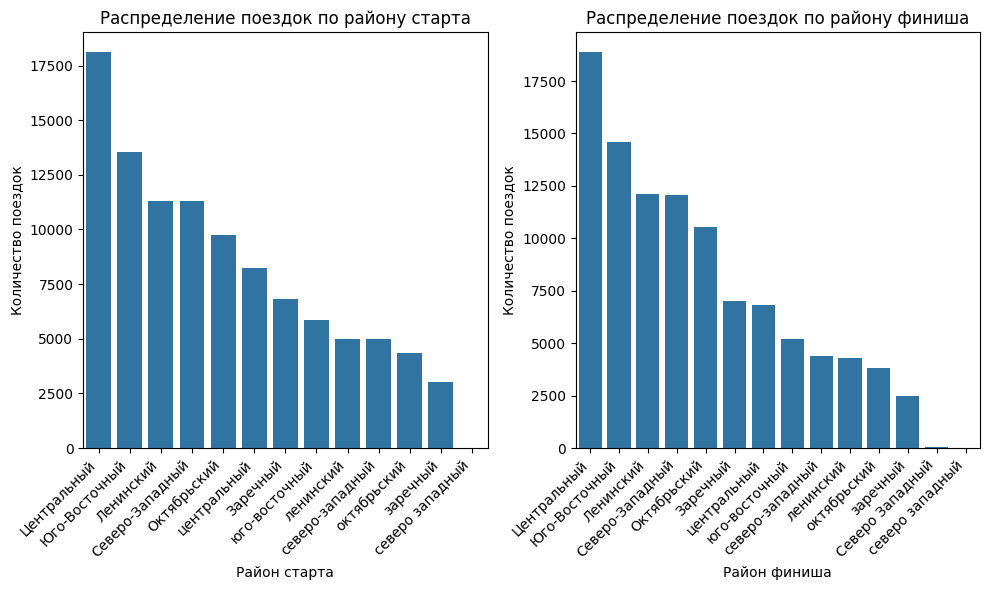

In [10]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df_rides, x='start_district', order=df_rides['start_district'].value_counts().index)
plt.title('Распределение поездок по району старта')
plt.xlabel('Район старта')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.countplot(data=df_rides, x='end_district', order=df_rides['end_district'].value_counts().index)
plt.title('Распределение поездок по району финиша')
plt.xlabel('Район финиша')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Также исходя из графика мы видим, что есть опечатки в виде отсутствия "-", а также неправильного регистра.

In [11]:
df_rides["start_location"].unique()[:30]

array(['Шевченко', 'Чехова', 'Буденного', 'Труда', 'Первомайская',
       'Лесная', 'Пролетарская', 'Комарова', 'Западная', 'Свободы',
       'Коммунальная', 'Зеленая', 'Шоссейная', 'Центральная', 'буденного',
       'новая', 'Энтузиастов', 'ул.подгорная', 'Восточная', 'Лермонтова',
       'Школьная', 'Пушкина', 'подгорная', 'рябиновая', 'Солнечная',
       'Мичурина', 'ул труда', 'Партизанская', 'Вокзальная',
       'Комсомольская'], dtype=object)

In [12]:
df_rides["end_location"].unique()[:30]

array(['Майская', 'Спортивная', 'Суворова', 'Рабочая', 'Юбилейная',
       'Западная', 'Свободы', 'ул. западная', 'Озерная', 'ул. чкалова',
       'Строителей', 'ул. спортивная', 'Красная', 'Ул. Крупской',
       'ул.почтовая', 'гоголя', 'Сиреневая', 'ул.южная', 'Шоссейная',
       'Трудовая', 'Дружбы', 'Почтовая', 'Южная', 'космонавтов',
       'шевченко', 'ул. набережная', 'вишневая', 'Совхозная',
       'ул сосновая', 'ул. вишневая'], dtype=object)

видим опечатки связанные с присутствием/отсуствием ул.
так что уберём ул и точки из всех улиц

#### Датасет погоды

In [13]:
df_weather.head(5)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01T00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01T02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01T03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01T04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


In [14]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             3672 non-null   object 
 1   temperature          3617 non-null   float64
 2   precipitation_total  3642 non-null   float64
 3   wind_gust            3672 non-null   float64
 4   wind_speed           3656 non-null   float64
 5   cloud_cover_total    3652 non-null   float64
 6   sunshine_duration    3660 non-null   float64
dtypes: float64(6), object(1)
memory usage: 200.9+ KB


Размер датасета, а значит и количество измерений

In [15]:
df_weather.shape

(3672, 7)

найдём количество месяцев измерений

In [16]:
df_weather.shape[0] / 24 / 30

5.1

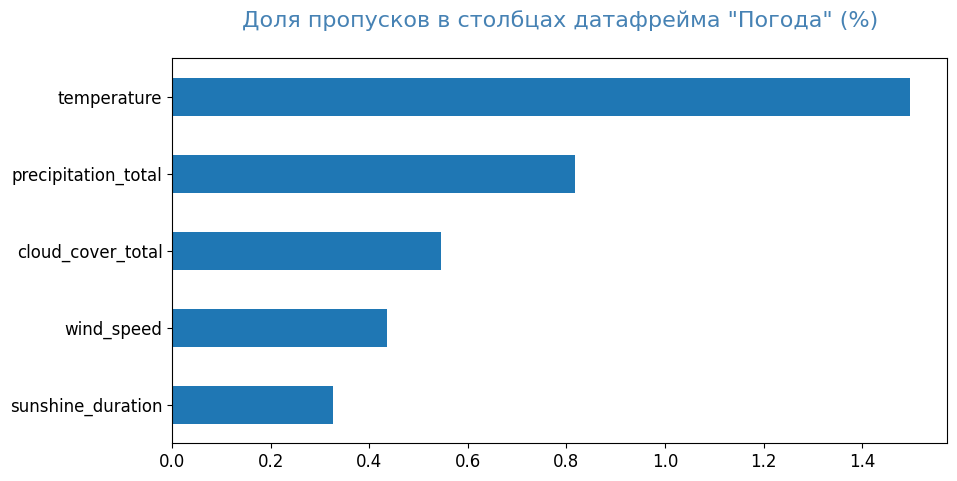

In [17]:
pass_value_barh(df_weather, "Погода")

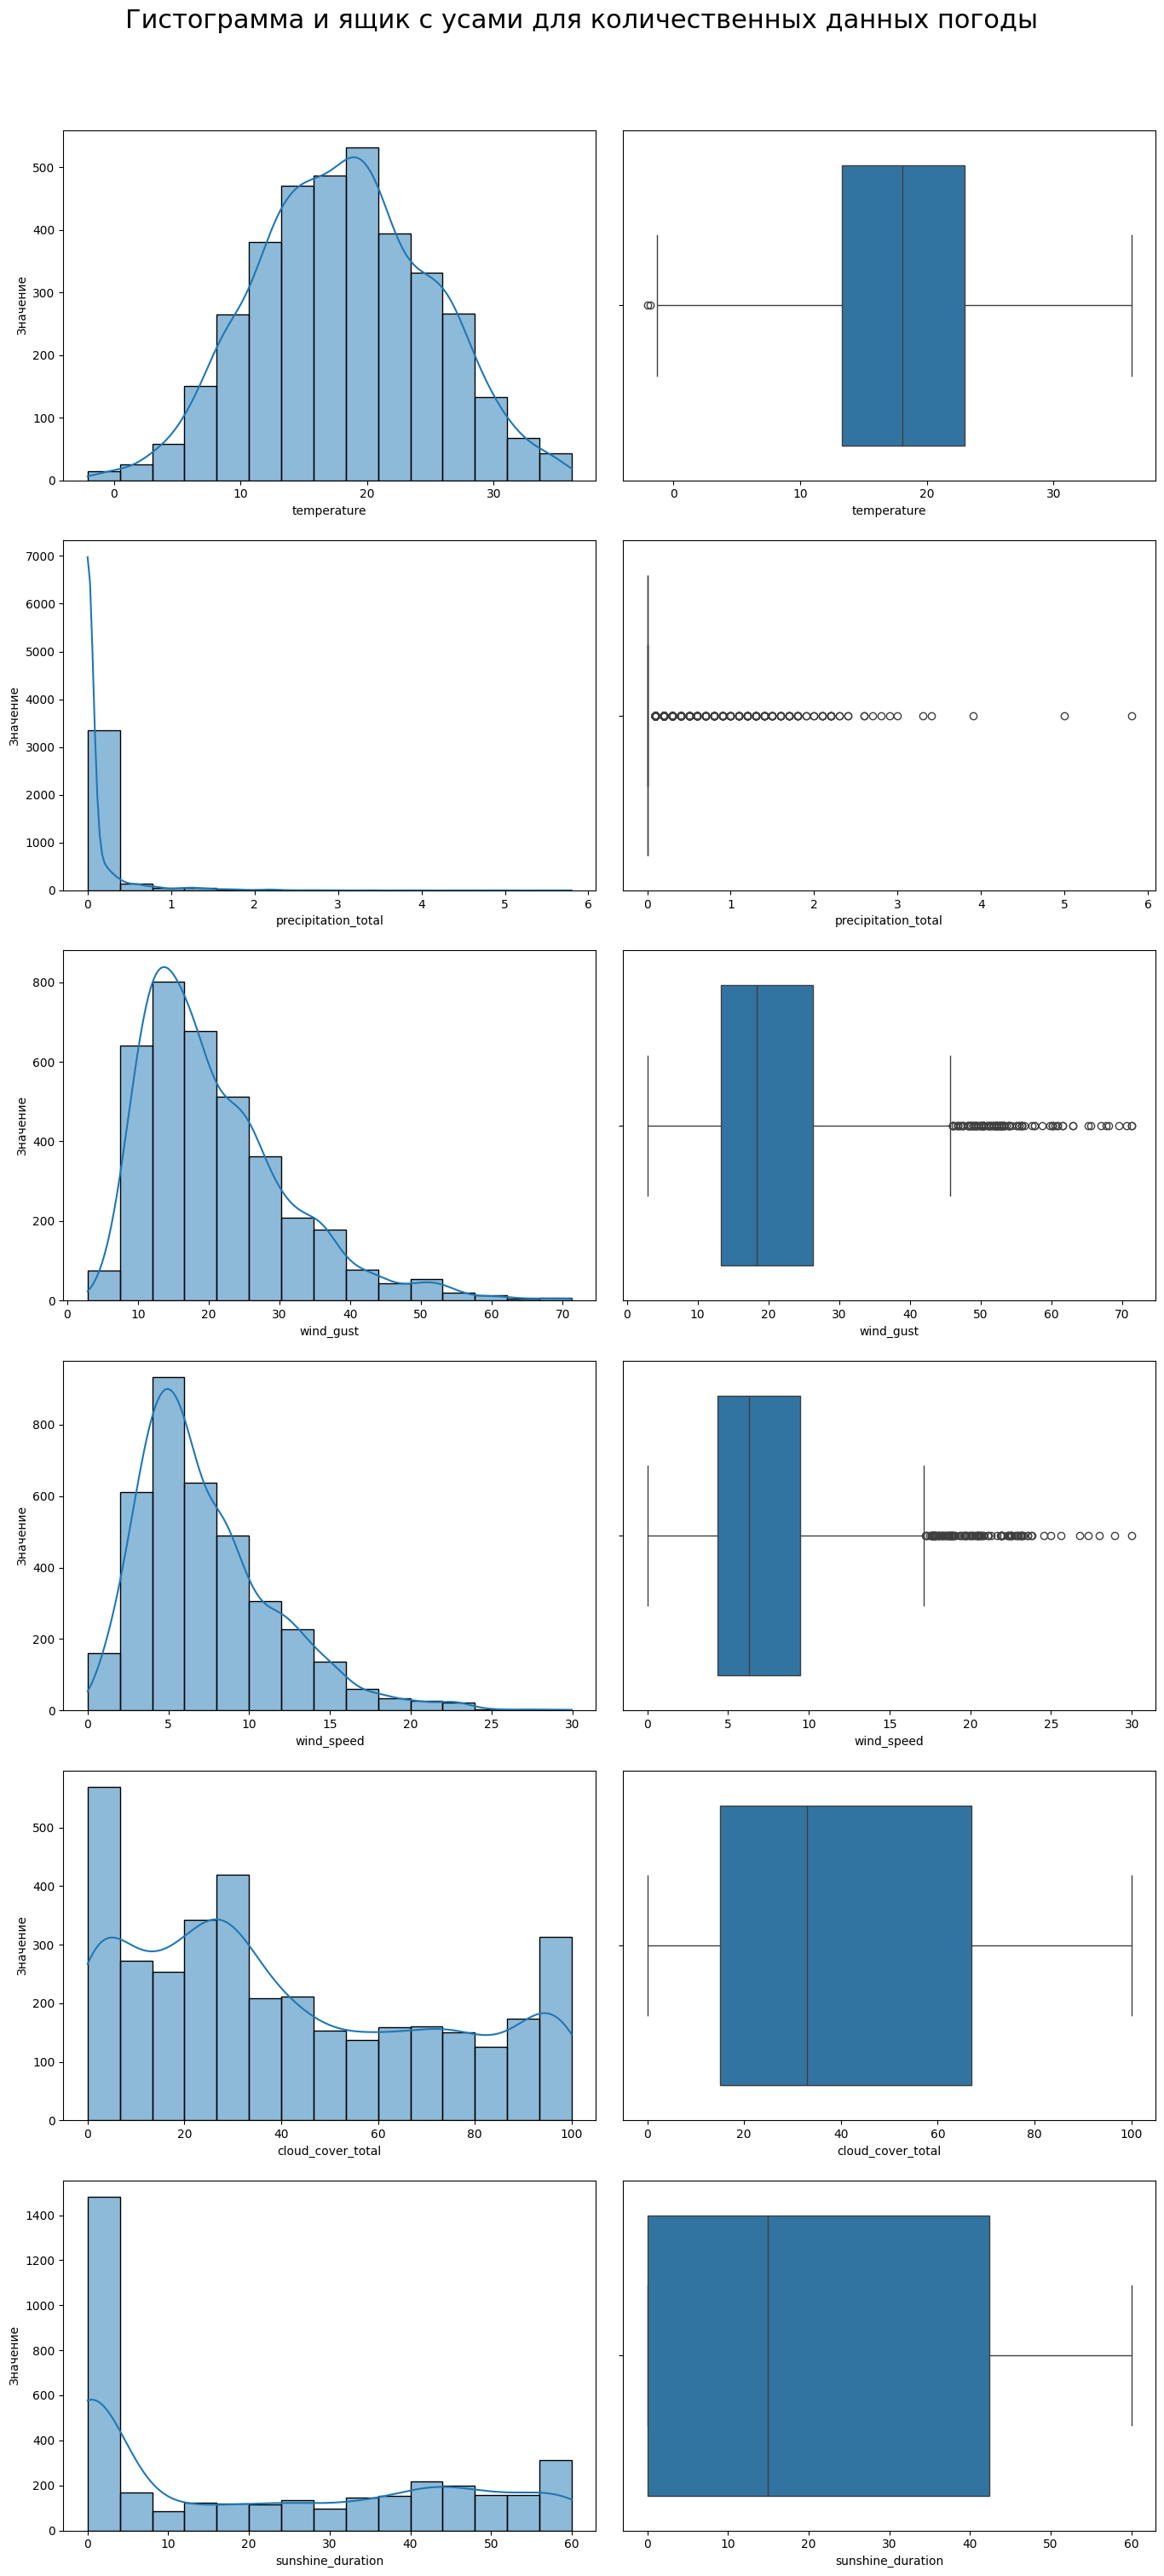

In [18]:
plot_hist(df_weather, integer_data(df_weather), "погоды")

### Исправление опечаток

In [19]:
for x in ["start_location", "end_location"]:
    df_rides = streets_format(df_rides, x)

for x in ["start_district", "end_district"]:
    df_rides = rayons_format(df_rides, x)

### Назначение типов данных

In [20]:
df_rides["promo"] = df_rides["promo"].astype(bool)
df_rides["start_date"] = pd.to_datetime(df_rides["start_date"])
df_rides["end_date"] = pd.to_datetime(df_rides["end_date"])
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])

### Работа с пропусками и выбросами в датасете поездок

####Выбросы

In [21]:
df_rides["duration"] = (df_rides["end_date"] - df_rides["start_date"]).apply(
    lambda x: x.total_seconds() / 60
)
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667


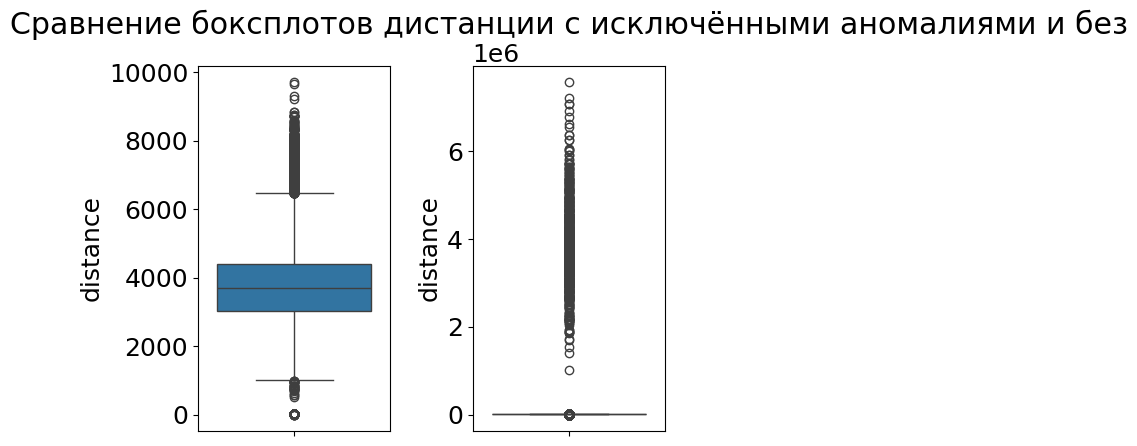

In [22]:
# Создаем два подграфика для сравнения распределения дистанции
plt.subplot(1, 2, 1)
# Строим boxplot для дистанций, исключая аномально большие значения (более 1,000,000)
sns.boxplot(df_rides[df_rides["distance"] < 1000000]["distance"])
# Создаем второй boxplot для всех дистанций, чтобы увидеть общую картину и выбросы
plt.subplot(1, 2, 2)
sns.boxplot(df_rides["distance"])
plt.title('Сравнение боксплотов дистанции с исключёнными аномалиями и без')
plt.tight_layout() # Added to prevent plots from overlapping
plt.show()

In [23]:
print(df_rides[df_rides["distance"] > 1000000]["distance"].shape[0], df_rides.shape[0])

622 102255


Выбросы по параметру distance начинаются с 1E6, остальные значения напоминают реальные (поездки на самокате в среднем около 4км, >=100км на самокате не проехать), выбросы по параметру distance можно заменить на среднее по группам

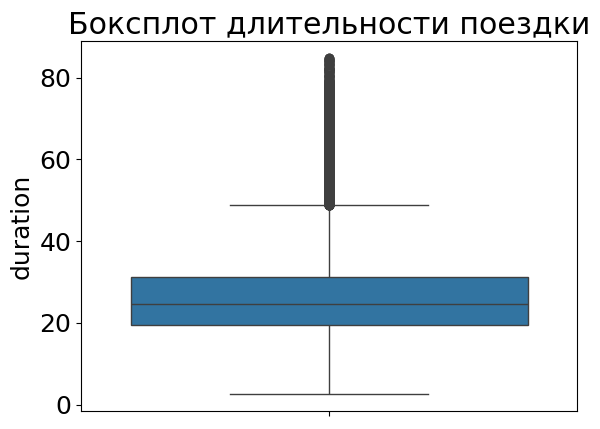

In [24]:
sns.boxplot(df_rides["duration"])
plt.title('Боксплот длительности поездки')
plt.show()

*   Пропуски есть только в 2 базовых столбцах - дистанция и
время окончания

*   Выбросы есть только в столбце distance, в этих столбцах можно просто заменить на среднее по группе (место и район старта и место и район финиша)

/tmp/ipython-input-3190274099.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[(x > 1000000) | (x < 10)] = None


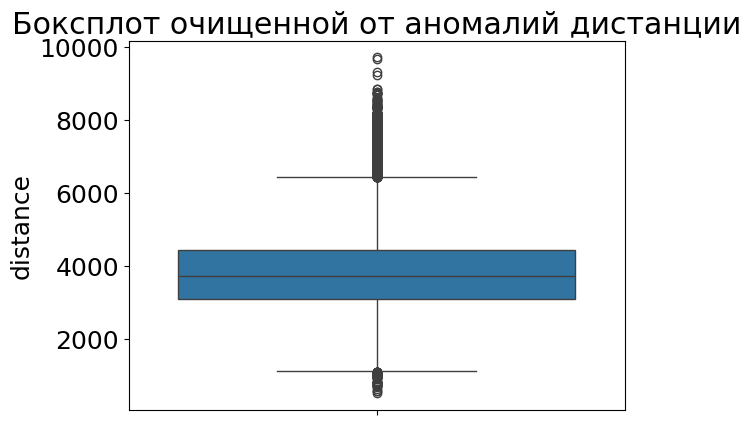

In [25]:
df_rides["distance"] = df_rides["distance"].transform(ejection)
sns.boxplot(df_rides["distance"])
plt.title('Боксплот очищенной от аномалий дистанции')
plt.show()

####Пропуски

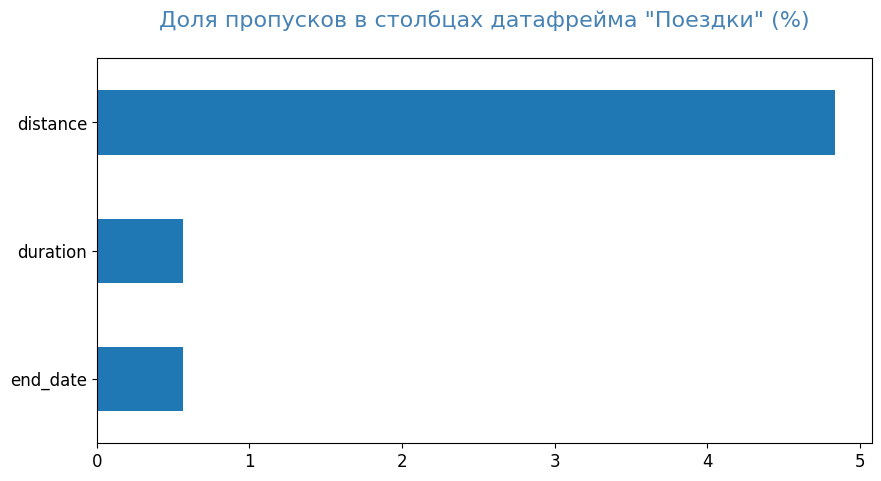

In [26]:
pass_value_barh(df_rides, "Поездки")

Найдём значения средней скорости поездки (метров в миунут) по группам и при помощи него зменим пропуски в дистанции.

In [27]:
df_rides["avg_speed"] = df_rides["distance"] / df_rides["duration"]
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [28]:
df_rides = df_rides.drop_duplicates(subset=["id"])

In [29]:
df_rides["avg_speed"] = df_rides.groupby(
    ["start_location", "start_district", "end_location", "end_district"]
)["avg_speed"].transform(
    lambda x: x.fillna(df_rides["avg_speed"].mean() if x.count() == 0 else x.mean())
)

df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [30]:
df_rides["distance"] = df_rides["distance"].fillna(
    df_rides["duration"] * df_rides["avg_speed"]
)
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [31]:
df_rides[df_rides["distance"].isna() & df_rides["duration"].isna()].shape[0]

18

In [32]:
df_rides[df_rides["distance"].isna()]

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
495,100807,2023-04-22 17:58:05,NaT,ломоносова,октябрьский,цветочная,северо-западный,NaN,False,NaN,161.769014
2546,102752,2023-04-24 19:41:16,NaT,октябрьская,заречный,комарова,ленинский,NaN,False,NaN,147.591056
2806,103006,2023-04-25 08:47:46,NaT,восточная,октябрьский,строительная,северо-западный,NaN,False,NaN,142.927047
10158,110004,2023-05-03 18:18:24,NaT,комсомольская,заречный,заводская,северо-западный,NaN,False,NaN,158.311131
15582,115182,2023-05-09 13:11:54,NaT,гоголя,центральный,дорожная,юго-восточный,NaN,False,NaN,148.929230
16517,116078,2023-05-10 18:54:16,NaT,мичурина,ленинский,восточная,октябрьский,NaN,False,NaN,154.040510
21876,121178,2023-05-16 18:30:32,NaT,майская,октябрьский,гагарина,центральный,NaN,False,NaN,145.933047
27939,126949,2023-05-23 06:44:52,NaT,крупской,центральный,буденного,октябрьский,NaN,False,NaN,175.021465
46102,144250,2023-06-09 21:59:33,NaT,энтузиастов,центральный,спортивная,октябрьский,NaN,False,NaN,157.147814
46473,144602,2023-06-10 11:46:28,NaT,спортивная,октябрьский,труда,центральный,NaN,False,NaN,156.840155


Существует 18 записей, где пропущена и дистанция и end_date, можно убрать их как статистический выброс, так как записи ничего не объединяет

In [33]:
df_rides = df_rides.dropna(subset=["distance"])

Пропуски в end_date найдём как: start_date + duration

In [34]:
df_rides["duration"] = df_rides["duration"].fillna(
    df_rides["distance"] / df_rides["avg_speed"]
)
df_rides["end_date"] = df_rides.apply(
    lambda row: (
        row["start_date"] + dt.timedelta(seconds=int(row["duration"] * 60))
        if pd.isna(row["end_date"])
        else row["end_date"]
    ),
    axis=1,
)
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


### Работа с пропусками и выбросами в датасете погоды

#### Выбросы

In [35]:
df_weather.head()

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01 00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01 02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01 03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01 04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


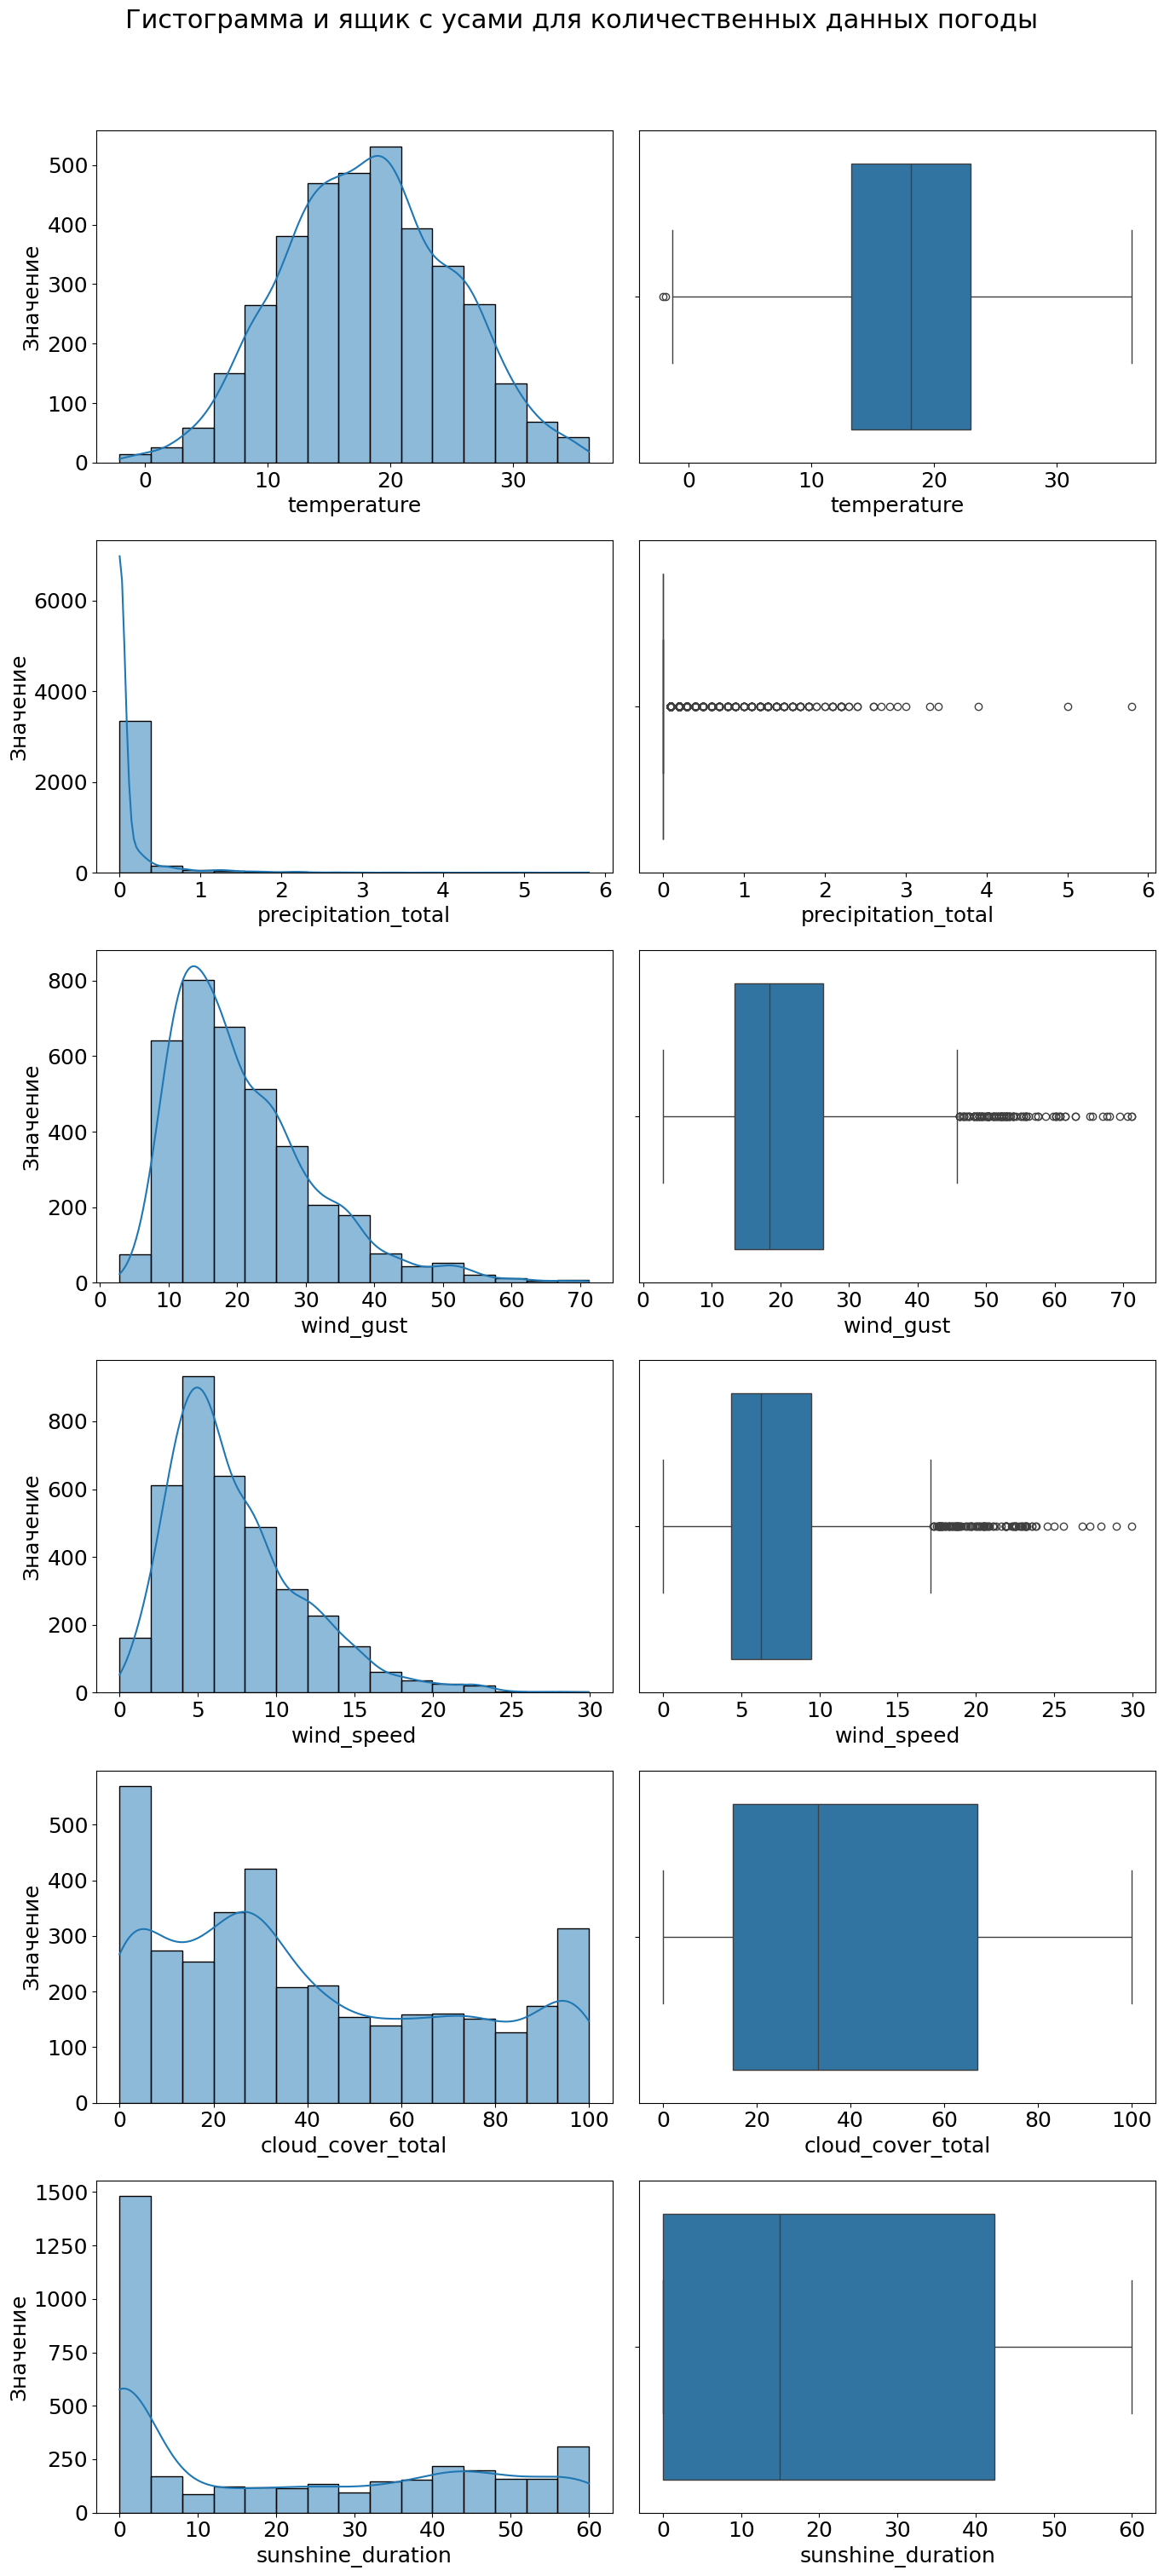

In [36]:
plot_hist(df_weather, integer_data(df_weather), "погоды")

In [37]:
df_weather.describe()

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
count,3672,3617.000000,3642.000000,3672.000000,3656.000000,3652.000000,3660.000000
mean,2023-06-16 11:30:00.000000256,18.137779,0.101043,20.886568,7.345096,41.056216,21.502410
min,2023-04-01 00:00:00,-2.079755,0.000000,2.880000,0.000000,0.000000,0.000000
25%,2023-05-09 05:45:00,13.270246,0.000000,13.320000,4.334974,15.000001,0.000000
50%,2023-06-16 11:30:00,18.100245,0.000000,18.359999,6.287130,33.000000,14.919949
75%,2023-07-24 17:15:00,23.010244,0.000000,26.280000,9.449572,67.000000,42.454547
max,2023-08-31 23:00:00,36.150246,5.800000,71.280000,29.966620,100.000000,60.000000
std,NaN,6.848331,0.343670,10.436531,4.265649,31.318514,21.896528


In [38]:
df_weather[df_weather["wind_gust"] > 60]

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
8,2023-04-01 08:00:00,8.640245,0.5,63.000000,20.371038,92.0,4.242425
9,2023-04-01 09:00:00,8.730246,0.6,60.120003,23.838959,88.0,6.666666
10,2023-04-01 10:00:00,9.150246,0.6,60.120003,23.199759,98.0,0.606061
13,2023-04-01 13:00:00,10.620245,0.4,60.479996,18.472595,98.0,0.606061
278,2023-04-12 14:00:00,13.800245,1.4,63.000000,18.837324,98.0,0.606061
279,2023-04-12 15:00:00,12.250245,0.9,60.839996,17.884428,80.0,9.696970
2963,2023-08-02 11:00:00,25.760244,0.0,68.039990,29.966620,81.0,10.909091
2964,2023-08-02 12:00:00,26.970245,0.0,71.280000,28.008370,80.0,11.515152
2965,2023-08-02 13:00:00,27.540245,0.0,70.560000,24.985659,70.0,17.575756
2966,2023-08-02 14:00:00,27.630245,0.0,61.560000,27.288855,61.0,23.030302


In [39]:
df_weather[df_weather["datetime"].dt.date == dt.date(2023, 8, 2)]

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
2952,2023-08-02 00:00:00,15.580245,0.0,18.720000,6.569383,98.0,0.000000
2953,2023-08-02 01:00:00,15.180245,0.0,17.640000,7.952660,92.0,0.000000
2954,2023-08-02 02:00:00,15.920245,0.0,18.000000,7.771331,98.0,0.000000
2955,2023-08-02 03:00:00,16.160246,0.4,19.080000,8.654986,100.0,0.000000
2956,2023-08-02 04:00:00,16.270247,0.5,19.080000,7.421590,100.0,0.000000
2957,2023-08-02 05:00:00,16.170246,0.3,23.039999,8.209263,100.0,0.000000
2958,2023-08-02 06:00:00,16.590246,0.6,31.319998,10.390226,100.0,0.000000
2959,2023-08-02 07:00:00,17.250246,0.8,30.599998,10.895577,100.0,0.000000
2960,2023-08-02 08:00:00,19.030245,0.3,34.920000,12.324414,97.0,1.212122
2961,2023-08-02 09:00:00,21.510244,0.0,38.880000,13.450708,47.0,31.515150


Все данные выглядят достаточно реально, оснований для подозрений на выбросы нет

скорость ветра в 29 км/ч по шкале Бофорта считается свежим ветром

порывы ветра до 71 км/ч также допустимы, учитывая что ветер был неслабым в эти дни, а также облачность на высоком уровне. Логично предположить, что это ураганные дни. Эта информация будет полезна в дальнейшем

#### Пропуски

In [40]:
df_weather.head()

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01 00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01 02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01 03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01 04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


In [41]:
df_weather.duplicated(subset="datetime").value_counts()

,count
False,3672


дубликатов нет

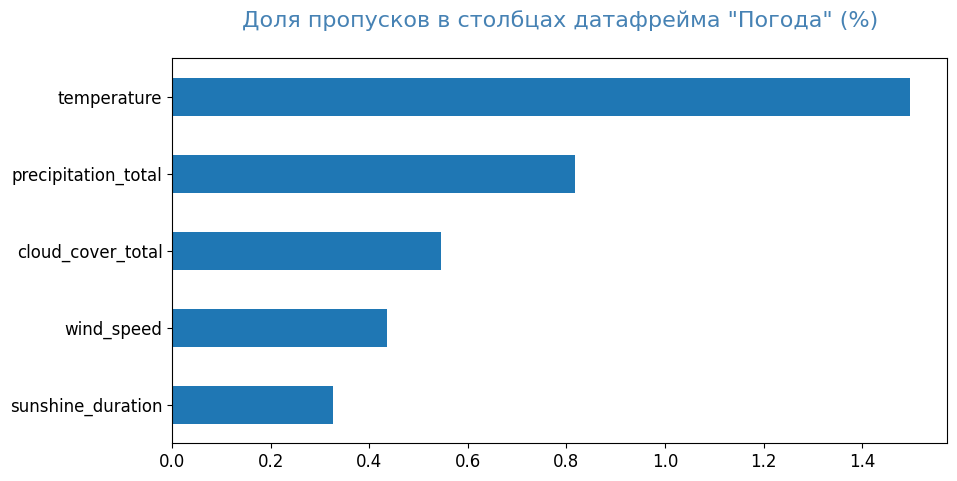

In [42]:
pass_value_barh(df_weather, "Погода")

In [43]:
df_weather = df_weather.interpolate(method="linear")

Интерполяция наиболее предпочтительна для данных, т.к. погода меняется постепенно и взаимосвязана по времени

Пропусков нет


Text(0.5, 1.0, 'Пропуски')

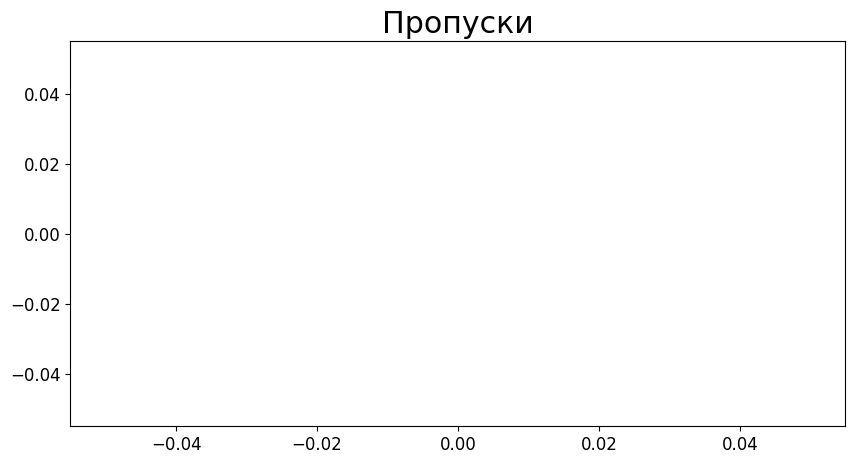

In [44]:
pass_value_barh(df_weather, "Погода")
plt.title('Пропуски')

### Аналитический и графический анализ

#### Посмотрим на неявные аномалии после предобработки

In [45]:
print(df_rides['avg_speed'].describe())


count    97354.000000
mean       153.191047
std         33.178950
min         37.999551
25%        131.425929
50%        153.106085
75%        174.701919
max        318.712871
Name: avg_speed, dtype: float64


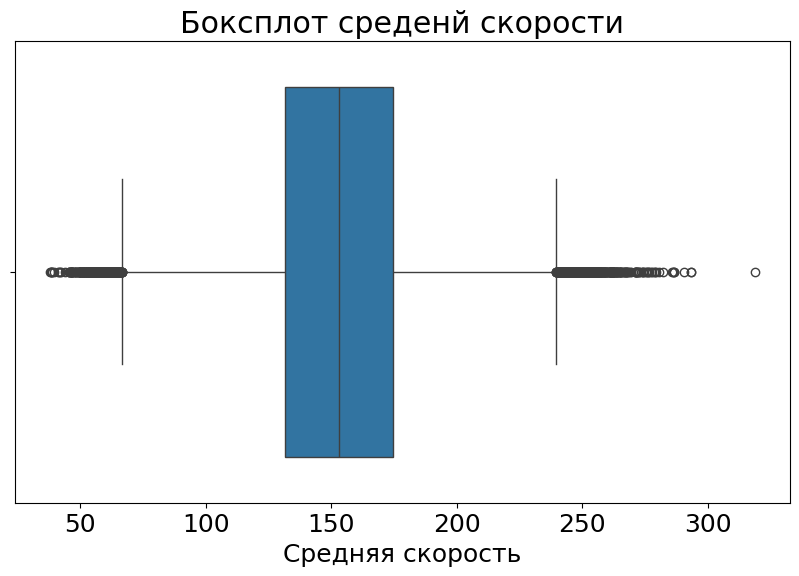

In [46]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_rides['avg_speed'])
plt.title('Боксплот среденй скорости')
plt.xlabel('Средняя скорость')
plt.show()

In [47]:
Q1 = df_rides['avg_speed'].quantile(0.25)
Q3 = df_rides['avg_speed'].quantile(0.75)
IQR = Q3 - Q1
print(f'Q1 (25th percentile): {Q1:.2f}')
print(f'Q3 (75th percentile): {Q3:.2f}')
print(f'IQR (Interquartile Range): {IQR:.2f}')

Q1 (25th percentile): 131.43
Q3 (75th percentile): 174.70
IQR (Interquartile Range): 43.28


In [48]:
upper_bound = Q3 + 3 * IQR
lower_bound = Q1 - 1.5 * IQR
print(f'Верхняя граница: {upper_bound:.2f}')
print(f'Нижняя граница: {lower_bound:.2f}')

Верхняя граница: 304.53
Нижняя граница: 66.51


In [49]:
anomalous_rides = df_rides[(df_rides['avg_speed'] < lower_bound) | (df_rides['avg_speed'] > upper_bound)]
print(f'Количество ненормальных поездок по статистике: {len(anomalous_rides)}')
display(anomalous_rides.head(10))

Количество ненормальных поездок по статистике: 382


,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
161,100493,2023-04-22 13:26:15,2023-04-22 14:05:01,калинина,ленинский,кирова,ленинский,2359.0,False,38.766667,60.851247
420,100736,2023-04-22 16:57:19,2023-04-22 17:51:41,колхозная,ленинский,дорожная,юго-восточный,3556.0,False,54.366667,65.407725
435,100751,2023-04-22 17:09:36,2023-04-22 18:23:37,речная,юго-восточный,спортивная,октябрьский,4466.0,False,74.016667,60.337762
564,100874,2023-04-22 18:37:57,2023-04-22 19:43:22,цветочная,северо-западный,комсомольская,заречный,4134.0,False,65.416667,63.194904
831,101127,2023-04-22 21:08:18,2023-04-22 22:25:35,коммунальная,юго-восточный,пушкина,центральный,4126.0,False,77.283333,53.387966
1201,101478,2023-04-23 11:35:33,2023-04-23 12:12:30,свободы,ленинский,комарова,ленинский,2308.0,False,36.950000,62.462788
1644,101898,2023-04-23 18:11:44,2023-04-23 19:11:44,заречная,юго-восточный,октябрьская,заречный,3977.0,False,60.000000,66.283333
1947,102187,2023-04-23 22:12:31,2023-04-23 23:22:11,пушкина,центральный,строителей,центральный,3914.0,False,69.666667,56.181818
2180,102406,2023-04-24 10:54:34,2023-04-24 12:06:21,строительная,северо-западный,шоссейная,заречный,3614.0,False,71.783333,50.345948
2508,102714,2023-04-24 19:11:01,2023-04-24 20:14:03,буденного,октябрьский,буденного,октябрьский,2418.0,False,63.033333,38.360656


> Выброс со сликшом большой скоростью только 1 и при этом он логически возможен.
>
> Выбросы со слишком маленькой скоростью являются менее логичными, но возможными по какой либо причине.

**Исходя из этого можно сделать вывод, что в среденй скорости аномалий не наблюадется.**

#### Просмотр финальных датасетов

##### Датасет поездок

In [50]:
df_rides.head(5)

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435


In [51]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97354 entries, 0 to 102254
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              97354 non-null  int64         
 1   start_date      97354 non-null  datetime64[ns]
 2   end_date        97354 non-null  datetime64[ns]
 3   start_location  97354 non-null  object        
 4   start_district  97354 non-null  object        
 5   end_location    97354 non-null  object        
 6   end_district    97354 non-null  object        
 7   distance        97354 non-null  float64       
 8   promo           97354 non-null  bool          
 9   duration        97354 non-null  float64       
 10  avg_speed       97354 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 8.3+ MB


In [52]:
df_rides = df_rides.drop("id", axis=1)

т.к. id нам нужен был только для нахождения дубликатов и не поможет в дальнейшем

In [53]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97354 entries, 0 to 102254
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_date      97354 non-null  datetime64[ns]
 1   end_date        97354 non-null  datetime64[ns]
 2   start_location  97354 non-null  object        
 3   start_district  97354 non-null  object        
 4   end_location    97354 non-null  object        
 5   end_district    97354 non-null  object        
 6   distance        97354 non-null  float64       
 7   promo           97354 non-null  bool          
 8   duration        97354 non-null  float64       
 9   avg_speed       97354 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(3), object(4)
memory usage: 7.5+ MB


Размер датасета, а значит и количество поездок

In [54]:
df_rides.shape[1]

10

In [55]:
df_rides["start_date"].min()

Timestamp('2023-04-22 09:01:03')

In [56]:
df_rides["start_date"].max()

Timestamp('2023-07-31 23:57:01')

нам представлены данные о поездках за 3 мес, тогда как данные о погоде за 5

In [57]:
df_rides.describe()

,start_date,end_date,distance,duration,avg_speed
count,97354,97354,97354.000000,97354.000000,97354.000000
mean,2023-06-13 21:07:54.995028736,2023-06-13 21:34:17.070762496,3831.604205,26.367974,153.191047
min,2023-04-22 09:01:03,2023-04-22 09:24:45,519.000000,2.566667,37.999551
25%,2023-05-20 21:43:06,2023-05-20 22:09:47.249999872,3103.000000,19.483333,131.425929
50%,2023-06-14 15:16:29.500000,2023-06-14 15:46:14,3734.500000,24.616667,153.106085
75%,2023-07-08 19:50:35,2023-07-08 20:19:23.249999872,4452.000000,31.216667,174.701919
max,2023-07-31 23:57:01,2023-08-01 00:42:12,13140.385605,84.833333,318.712871
std,NaN,NaN,1054.170770,9.942623,33.178950


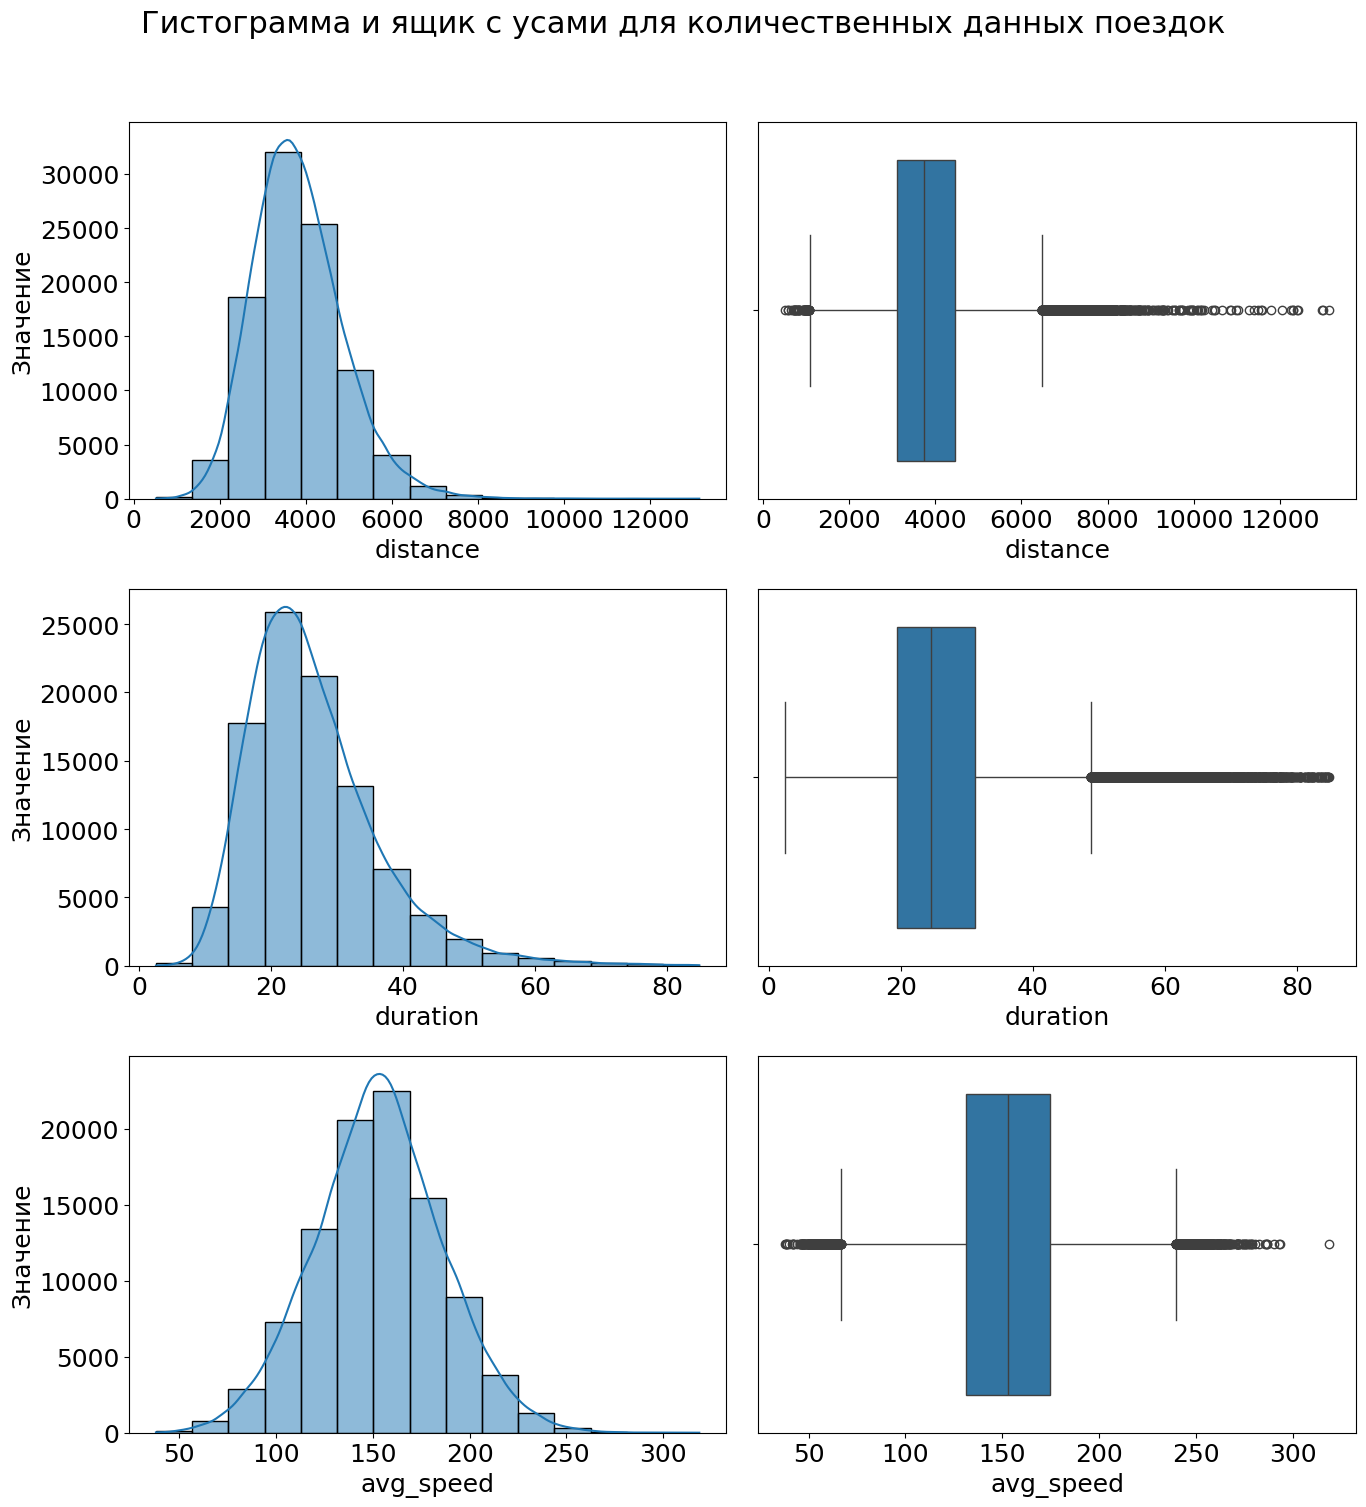

In [58]:
plot_hist(df_rides, integer_data(df_rides), "поездок")

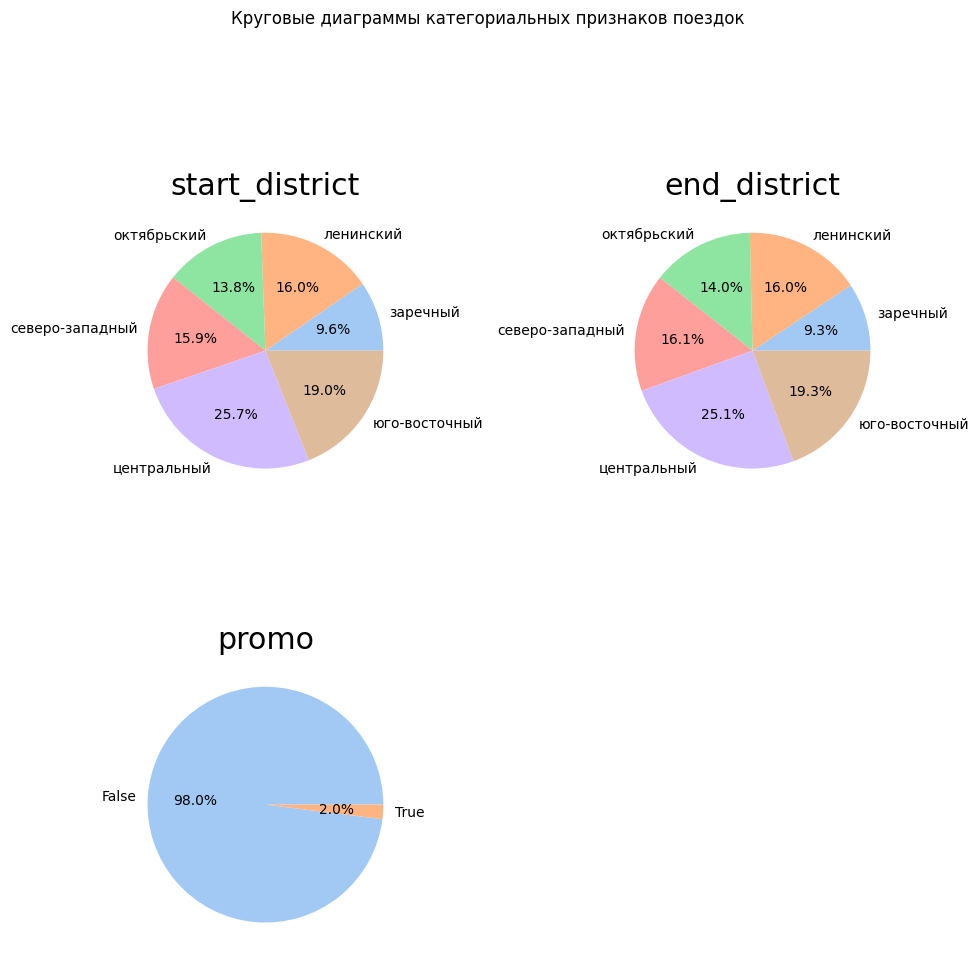

In [59]:
cat_graph(df_rides, ["start_district", "end_district", "promo"], "поездок")

##### Датасет погоды

In [60]:
df_weather.head(5)

,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01 00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01 02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01 03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01 04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


In [61]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3672 non-null   float64       
 2   precipitation_total  3672 non-null   float64       
 3   wind_gust            3672 non-null   float64       
 4   wind_speed           3672 non-null   float64       
 5   cloud_cover_total    3672 non-null   float64       
 6   sunshine_duration    3672 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 200.9 KB


Размер датасета, а значит и количество измерений

In [62]:
df_weather.shape

(3672, 7)

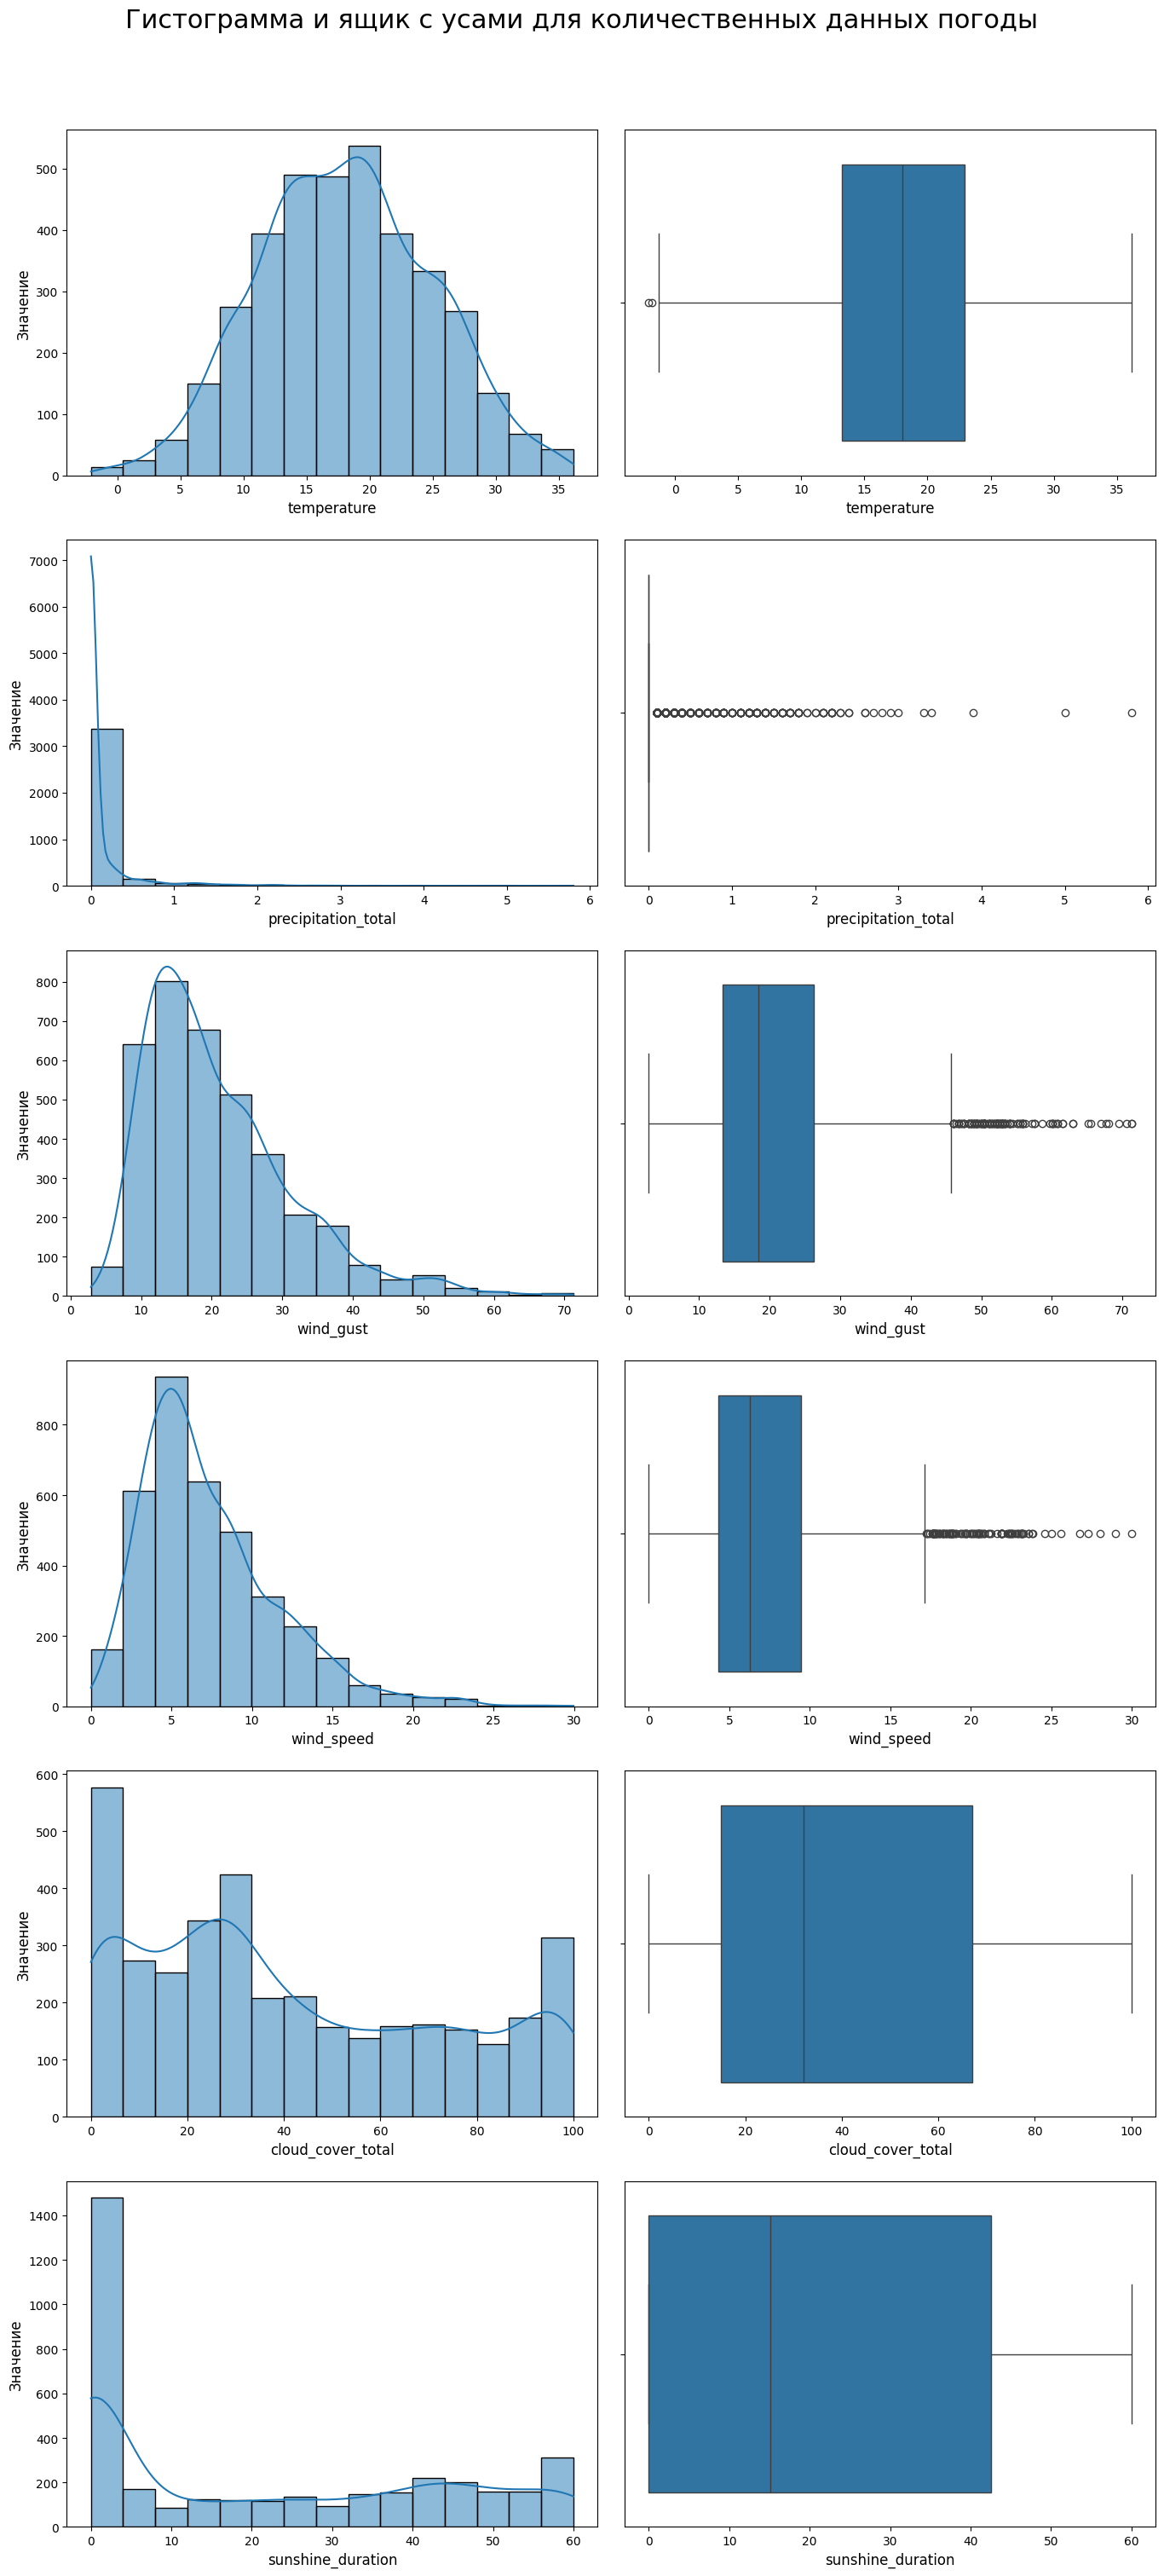

In [63]:
plot_hist(df_weather, integer_data(df_weather), "погоды")

## Выводы по EDA

1. Наиболее популярный регион для поездок - центральный, а наименее популярный - заречный

2. Было совершено 97354 поездок

3. Промокодом воспользовались в 2% поездок

4. Имеем поездки на протяжении 3 месяцев и данные об измерениях на протяжении 5

5. Средняя дистанция поездки - около 4 километров, средняя длительность 26 минут, средняя скорость 153 метра/минуту

## Расчётные задачи

### Feature engineering

Сделаем столбец с группой поездки по врмени

In [64]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour
conditions = [
    (df_rides["start_hour"] >= 1) & (df_rides["start_hour"] < 6),
    (df_rides["start_hour"] >= 6) & (df_rides["start_hour"] < 10),
    (df_rides["start_hour"] >= 10) & (df_rides["start_hour"] < 16),
    (df_rides["start_hour"] >= 16) & (df_rides["start_hour"] < 22),
    (df_rides["start_hour"] >= 22) | (df_rides["start_hour"] < 1),
]
choices = [1, 2, 3, 4, 5]
df_rides["group_of_time"] = np.select(conditions, choices)
df_rides = df_rides.drop("start_hour", axis=1)
df_rides.head()

,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed,group_of_time
0,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764,2
1,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630,2
2,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332,2
3,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094,2
4,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435,2


Далее сделаем столбец с указанием дня недели по порядку

In [65]:
df_rides["day_of_week"] = df_rides["start_date"].dt.dayofweek + 1

In [66]:
promo_rides = df_rides[df_rides['promo'] == True]
is_valid_promo = (promo_rides['group_of_time'] == 2) & (promo_rides['day_of_week'] == 1)

if is_valid_promo.all():
    print("Все поездки с True в промо соответствуют 2 группе времени и понедельнику.")
else:
    print("Есть поездки с True в промо, которые НЕ соответствуют 2 группе времени и понедельнику.")

Все поездки с True в промо соответствуют 2 группе времени и понедельнику.


Сделаем колонку с указанием периода врмени(утро, день, ночь). Для этого взглянем на график распределение активности клиентов по врмени.

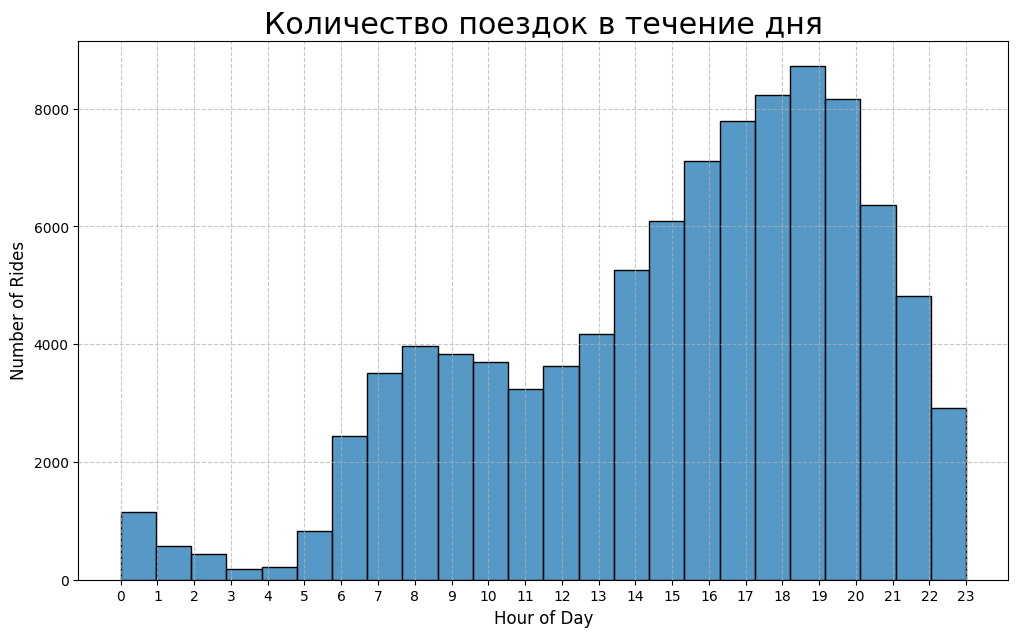

In [67]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour

plt.figure(figsize=(12, 7))
sns.histplot(df_rides["start_hour"], bins=24, kde=False)
plt.title("Количество поездок в течение дня")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

df_rides = df_rides.drop("start_hour", axis=1)

Исходя из графика мы видим 3 разных 'бугорка' с 23:00 до 6:00; c 7:00 до 13:00; c 14 до 22

In [68]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour
conditions = [
    (df_rides["start_hour"] >= 23) | (df_rides["start_hour"] <= 6),
    (df_rides["start_hour"] >= 7) & (df_rides["start_hour"] <= 13),
    (df_rides["start_hour"] >= 14) & (df_rides["start_hour"] <= 22),
]
choices = ["ночь", "утро", "день"]
df_rides["period_of_time"] = np.select(conditions, choices, default="unknown")
df_rides = df_rides.drop("start_hour", axis=1)

df_rides.head()

,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed,group_of_time,day_of_week,period_of_time
0,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764,2,6,утро
1,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630,2,6,утро
2,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332,2,6,утро
3,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094,2,6,утро
4,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435,2,6,утро


### Расчёт цены поездки

Рассчитаем цену с учётом акции

In [69]:
df_rides["cost_per_minute"] = df_rides.apply(calculate_cost_per_minute, axis=1)
df_rides["base_cost"] = df_rides["promo"].apply(lambda x: 0 if x else 30)
df_rides["cost"] = df_rides["base_cost"] + (
    df_rides["duration"] * df_rides["cost_per_minute"]
)

df_rides = df_rides.drop(columns=["cost_per_minute", "base_cost"])

#### Найдём прирост активности от акции

Для этого найдём наиболее "похожий" на понедельник день и сравним среднее количество поездок в период проведения акции (с 6:00 до 10:00) и в "похожий день" без акции (в этот же период времени)

**Для нахождения "похожего" на понедельник дня:**

Берём время в понедельник, не принадлежащее акции (наример с 10:00 до 16:00). И сравниваем статистики в других днях недели для этого же времени.

Посмотрим на самый похожий день

In [70]:
# дата сеты с записями по разным дням недели не включающие время проведения акции
for day in range(1, 8):
    globals()[f"df_day{day}"] = df_rides[
        (df_rides["day_of_week"] == day) & (df_rides["group_of_time"] != 2)
    ]

In [71]:
day_dataframes = {
    "df_day1": df_day1,
    "df_day2": df_day2,
    "df_day3": df_day3,
    "df_day4": df_day4,
    "df_day5": df_day5,
    "df_day6": df_day6,
    "df_day7": df_day7,
}
most_similar_day1, similarity_score1 = find_most_similar_day(day_dataframes)
print(
    f"Самый похожий день: {most_similar_day1} с коэффициентом 'схожести' {similarity_score1:.4f}"
)

Самый похожий день: df_day2 с коэффициентом 'схожести' 1.9911


На основе анализа был выявлен самый похожий день: вторник с коэффициентом 'схожести' 1.9911

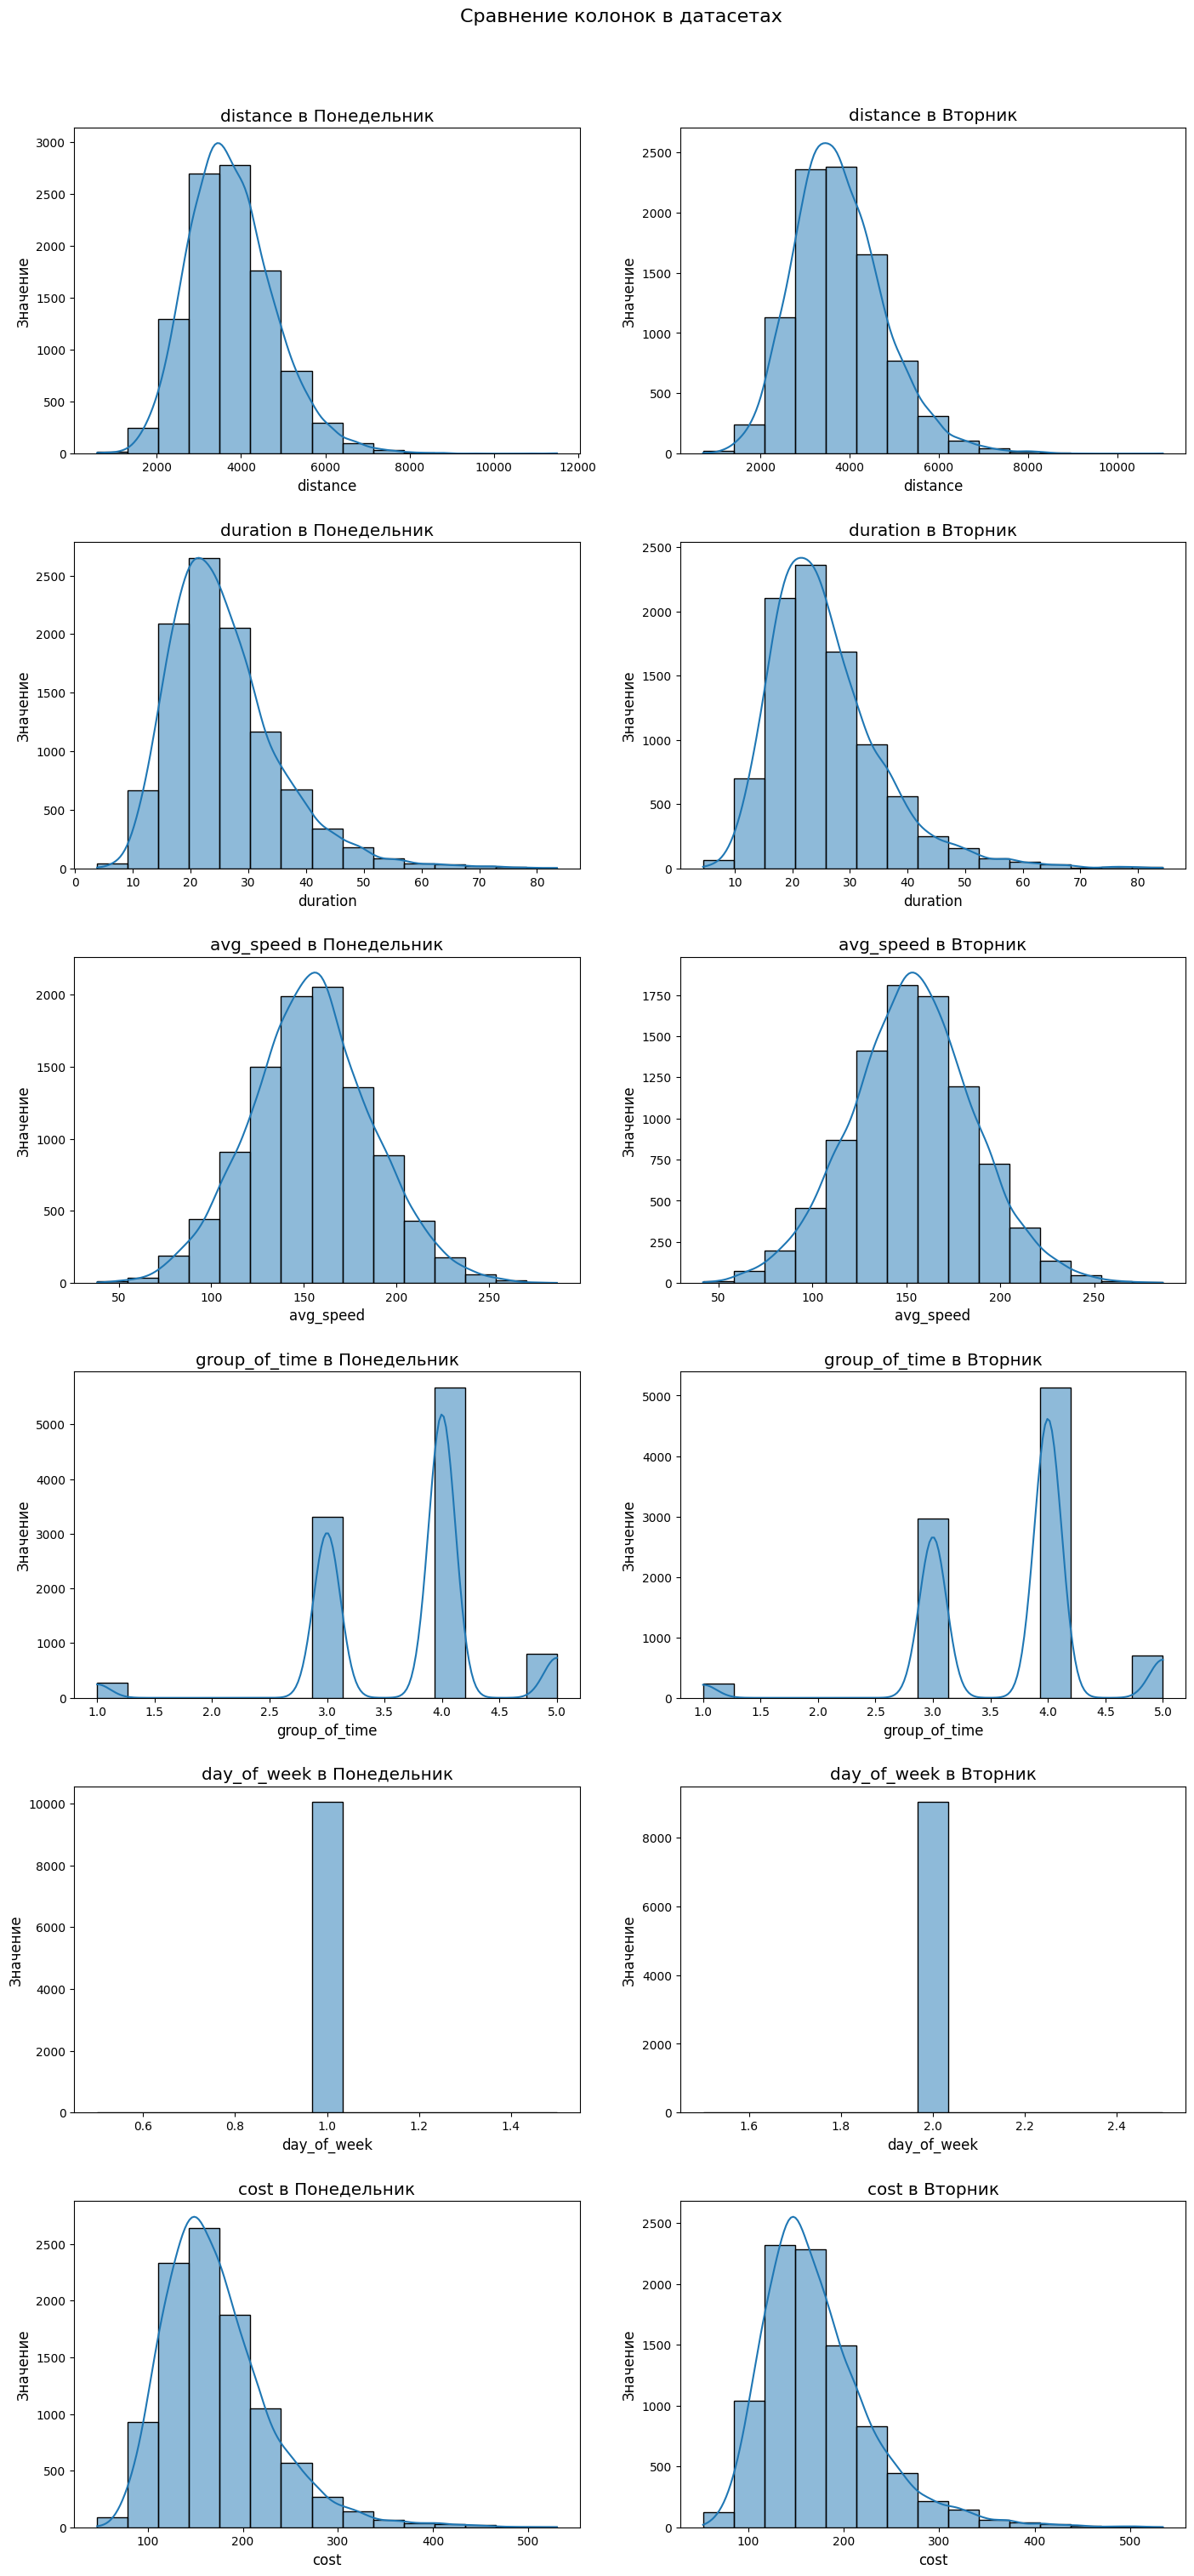

In [72]:
plot_comparison_histograms(
    df_day1,
    df_day2,
    integer_data(df_day1),
    df1_title="Понедельник",
    df2_title="Вторник",
)

Исходя из аналитического и графического анализа делаем вывод, что вторник имеет наиболее похожие статистики на понедельник, в период не проведения акции.
Следовательно для дальнейшего сравнения с дата сетом с акцией мы будем использовать вторник в этот же период времени.

In [73]:
df_promotion = df_rides[
    (df_rides["day_of_week"] == 1) & (df_rides["group_of_time"] == 2)
]
df_not_promotion = df_rides[
    (df_rides["day_of_week"] == 2) & (df_rides["group_of_time"] == 2)
]

Теперь мы можем определиить окупаемость акции и увеличение спроса, сравнив прибыль и спрос в период проведения акции с этим же периодом врмени во вторник

In [74]:
profit_in_monday = df_promotion["cost"].sum()
profit_in_tuesday = df_not_promotion["cost"].sum()

rides_promotion = df_promotion.shape[0]
avg_distance_promotion = df_promotion["distance"].mean()
avg_duration_promotion = df_promotion["duration"].mean()

rides_not_promotion = df_not_promotion.shape[0]
avg_distance_not_promotion = df_not_promotion["distance"].mean()
avg_duration_not_promotion = df_not_promotion["duration"].mean()

avg_profit_promotion = profit_in_monday / rides_promotion
avg_profit_not_promotion = profit_in_tuesday / rides_not_promotion

print("--- Период акции (Понедельник, 06:00-10:00) ---")
print(f"Прибыль: {profit_in_monday:.2f}")
print(f"Количество поездок: {rides_promotion}")
print(f"Средняя дистанция поездки: {avg_distance_promotion:.2f}")
print(f"Средняя продолжительсноть поездки: {avg_duration_promotion:.2f}")
print(f"Средняя прибыль за поездку: {avg_profit_promotion:.2f}")

print("\n--- Период в которыйй акция не проводится (Вторник, 06:00-10:00) ---")
print(f"Прибыль: {profit_in_tuesday:.2f}")
print(f"Количество поездок: {rides_not_promotion}")
print(f"Средняя дистанция поездки: {avg_distance_not_promotion:.2f}")
print(f"Средняя продолжительсноть поездки: {avg_duration_not_promotion:.2f}")
print(f"Средняя прибыль за поездку: {avg_profit_not_promotion:.2f}")

--- Период акции (Понедельник, 06:00-10:00) ---
Прибыль: 287588.11
Количество поездок: 2675
Средняя дистанция поездки: 3782.61
Средняя продолжительсноть поездки: 24.74
Средняя прибыль за поездку: 107.51

--- Период в которыйй акция не проводится (Вторник, 06:00-10:00) ---
Прибыль: 276373.89
Количество поездок: 2152
Средняя дистанция поездки: 3798.04
Средняя продолжительсноть поездки: 24.61
Средняя прибыль за поездку: 128.43


*Уменьшение средней прибыли за поездку обуславливается уменьшением её цены на 30 рублей*

### Выводы по задаче

Исходя из приведённых выше статистик мы можем сделать вывод:


*   Акция стимулирует спрос на самокаты (так как значительно увеличилось количество поездок)
*   Акция окупает себя (Прибыль за период проведения акции выше, чем в период не проведения акции при других примерно равных сатистиках)



### Таблица с почасовым трафиком в каждой точке

*   Создаём таблицу с трафиком
*   Смотрим лучшие и худшие точки по трафику
*   Анализируем прибыль точки для рассмотрения возможности закрытия или открытия точек в разных районах
*  Исследуем направления направления перермещения между точками и районам
*   Считаем разницу в трафике и исследуем её (Профициты и дефициты)
*   Находим оптимальное количество самокатов

#### Считаем трафик по точкам

Считаем количество в начале часа и в конце часа

In [75]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour
df_rides["end_hour"] = df_rides["end_date"].dt.hour

hourly_scooters_started = df_rides.groupby(["start_hour", "start_location"]).size().reset_index(name="count")
hourly_scooters_ended = df_rides.groupby(["end_hour", "end_location"]).size().reset_index(name="count")

print("Количество в начале часа:")
print(hourly_scooters_started.head())
print("Количество в конце часа:")
print(hourly_scooters_ended.head())

Количество в начале часа:
   start_hour start_location  count
0           0      береговая     11
1           0      березовая     12
2           0      буденного     28
3           0       вишневая      7
4           0     вокзальная     13
Количество в конце часа:
   end_hour end_location  count
0         0    береговая     18
1         0    березовая     28
2         0    буденного     48
3         0     вишневая     11
4         0   вокзальная     20


Сделаем колонку трафик

In [76]:
hourly_scooters_started_renamed = hourly_scooters_started.rename(columns={'count': 'start_count', 'start_hour': 'hour', 'start_location': 'location'})
hourly_scooters_ended_renamed = hourly_scooters_ended.rename(columns={'count': 'end_count', 'end_hour': 'hour', 'end_location': 'location'})

df_hourly_traffic = pd.merge(
    hourly_scooters_started_renamed,
    hourly_scooters_ended_renamed,
    on=['hour', 'location'],
    how='outer'
).fillna(0)

df_hourly_traffic['traffic'] = df_hourly_traffic['start_count'] + df_hourly_traffic['end_count']

print("df_hourly_traffic head:")
print(df_hourly_traffic.head())

df_hourly_traffic head:
   hour    location  start_count  end_count  traffic
0     0   береговая         11.0       18.0     29.0
1     0   березовая         12.0       28.0     40.0
2     0   буденного         28.0       48.0     76.0
3     0    вишневая          7.0       11.0     18.0
4     0  вокзальная         13.0       20.0     33.0


In [79]:
df_filtered_traffic = df_hourly_traffic.sort_values(by='traffic', ascending=False).copy()
df_average_traffic_by_period = df_filtered_traffic.groupby('location')['traffic'].mean().reset_index(name='avg_traffic')

print(df_average_traffic_by_period.head())

     location  avg_traffic
0   береговая    71.041667
1   березовая   102.041667
2   буденного   186.041667
3    вишневая    71.916667
4  вокзальная    71.833333




---



In [80]:
df_rides_hourly_traffic_final = df_hourly_traffic.pivot_table(
    index='location',
    columns='hour',
    values='traffic',
    fill_value=0
)
df_rides_hourly_traffic_final.head(5)

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
location,,,,,,,,,,,,,,,,,,,,,
береговая,29.0,12.0,5.0,3.0,8.0,3.0,34.0,50.0,67.0,68.0,...,100.0,101.0,115.0,130.0,160.0,161.0,132.0,132.0,96.0,60.0
березовая,40.0,17.0,10.0,13.0,1.0,19.0,56.0,85.0,99.0,87.0,...,103.0,142.0,168.0,212.0,197.0,234.0,201.0,179.0,124.0,82.0
буденного,76.0,44.0,21.0,19.0,11.0,34.0,124.0,142.0,211.0,205.0,...,243.0,245.0,304.0,330.0,373.0,371.0,364.0,286.0,223.0,139.0
вишневая,18.0,8.0,4.0,4.0,6.0,14.0,28.0,62.0,74.0,65.0,...,86.0,102.0,142.0,143.0,116.0,151.0,159.0,125.0,90.0,59.0
вокзальная,33.0,8.0,5.0,4.0,4.0,17.0,34.0,53.0,76.0,57.0,...,101.0,102.0,99.0,135.0,135.0,166.0,138.0,139.0,100.0,73.0


In [81]:
df_rides_hourly_traffic_final["total_count_rides"] = df_rides_hourly_traffic_final.sum(axis=1)
df_rides_hourly_traffic_final = df_rides_hourly_traffic_final.sort_values(
    by="total_count_rides", ascending=False
)
df_rides_hourly_traffic_final.head()

hour,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,total_count_rides
location,,,,,,,,,,,,,,,,,,,,,
луговая,69.0,30.0,19.0,11.0,8.0,31.0,93.0,158.0,160.0,192.0,...,266.0,307.0,340.0,386.0,406.0,405.0,334.0,252.0,143.0,4562.0
ломоносова,74.0,35.0,29.0,10.0,10.0,36.0,101.0,151.0,171.0,169.0,...,267.0,325.0,382.0,379.0,389.0,401.0,314.0,234.0,137.0,4538.0
спортивная,69.0,34.0,31.0,13.0,13.0,27.0,107.0,155.0,188.0,174.0,...,246.0,286.0,360.0,379.0,398.0,390.0,320.0,229.0,169.0,4505.0
майская,71.0,36.0,17.0,16.0,9.0,33.0,93.0,134.0,189.0,179.0,...,283.0,341.0,364.0,361.0,435.0,383.0,294.0,233.0,150.0,4491.0
восточная,78.0,30.0,21.0,11.0,14.0,27.0,107.0,135.0,183.0,180.0,...,266.0,320.0,350.0,380.0,400.0,360.0,293.0,266.0,174.0,4483.0


In [82]:
sum_total_rides = df_rides_hourly_traffic_final["total_count_rides"].sum().astype(int)
print(sum_total_rides)

194708


**Суммарное количество поездок за всё время 194708**

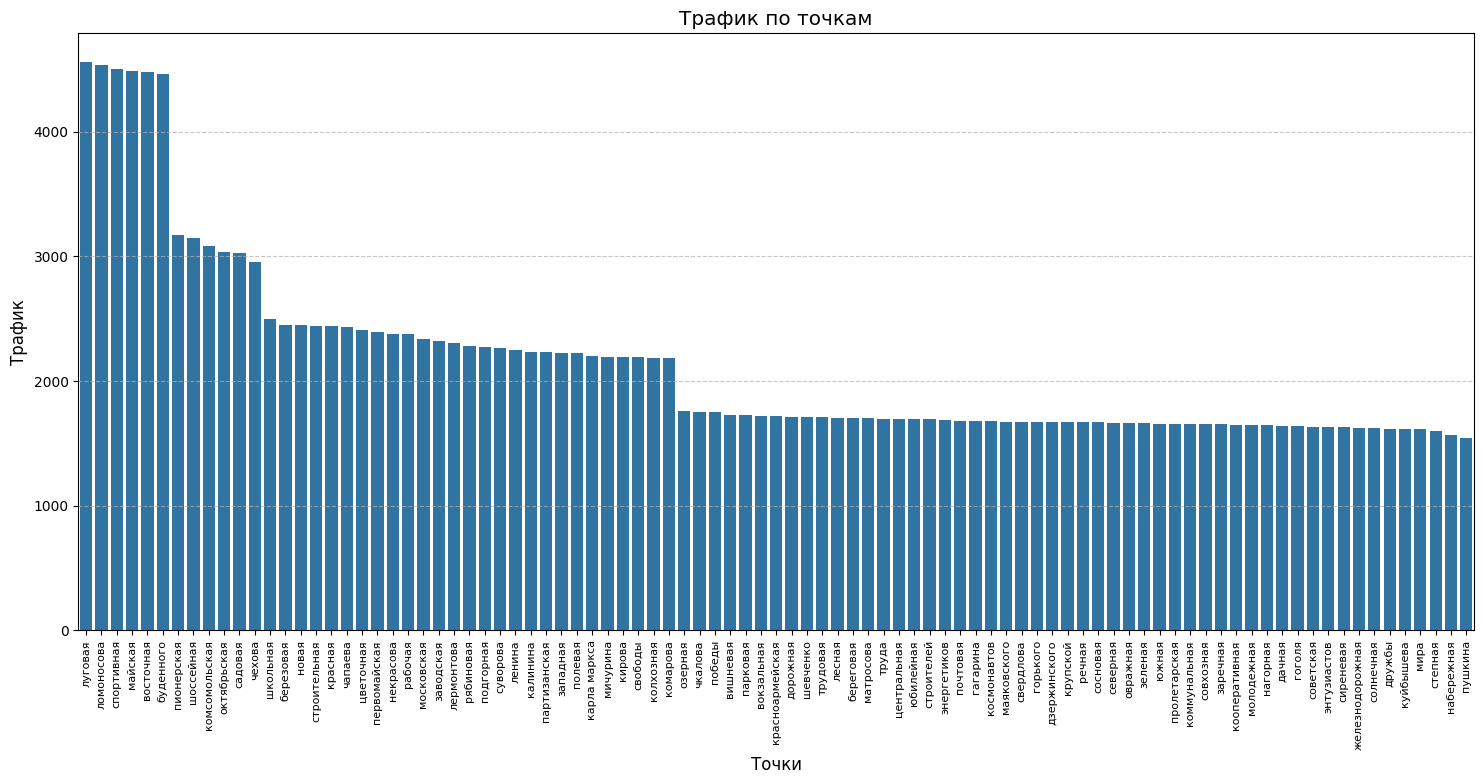

In [179]:
plt.figure(figsize=(15, 8))
sns.barplot(
    x=df_rides_hourly_traffic_final.index,
    y="total_count_rides",
    data=df_rides_hourly_traffic_final,
)
plt.title("Трафик по точкам")
plt.xlabel("Точки")
plt.ylabel("Трафик")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Анализ трафика

Посмомтрим на количество точек в районах

In [181]:
df_location_district = df_rides[['start_location', 'start_district']].drop_duplicates().copy()

In [186]:
top_of_tails_locations_with_district_counts = (
    df_location_district.groupby("start_district")
    .size()
    .reset_index(name="count_location").sort_values(by='count_location',  ascending=False)
)
top_of_tails_locations_with_district_counts

,start_district,count_location
4,центральный,30
5,юго-восточный,22
1,ленинский,14
3,северо-западный,13
0,заречный,6
2,октябрьский,6


Сделаем таблицу с доходом по точкам за каждый день для анализа доходности от лучших и худших по трафику точек

In [187]:
df_rides["start_date_day"] = df_rides["start_date"].dt.date
df_rides["end_date_day"] = df_rides["end_date"].dt.date

df_rides.head()

,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed,group_of_time,day_of_week,period_of_time,cost,start_hour,end_hour,start_date_day,end_date_day
0,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764,2,6,утро,124.800000,9,9,2023-04-22,2023-04-22
1,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630,2,6,утро,143.666667,9,9,2023-04-22,2023-04-22
2,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332,2,6,утро,183.266667,9,9,2023-04-22,2023-04-22
3,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094,2,6,утро,157.266667,9,9,2023-04-22,2023-04-22
4,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435,2,6,утро,152.666667,9,9,2023-04-22,2023-04-22


In [188]:
df_daily_started = df_rides.groupby(['start_location', 'start_date_day']).agg(
    started_rides=('start_location', 'count'),
    started_profit=('cost', 'sum')
).reset_index()

df_daily_started.rename(columns={'start_location': 'location', 'start_date_day': 'date'}, inplace=True)

print("Смотрим профит от начального количества самокатов")
display(df_daily_started.head())

Daily started rides and profit:


,location,date,started_rides,started_profit
0,береговая,2023-04-22,6,964.283333
1,береговая,2023-04-23,6,1000.100000
2,береговая,2023-04-24,6,988.900000
3,береговая,2023-04-25,5,701.083333
4,береговая,2023-04-26,5,863.400000


In [189]:
df_daily_ended = df_rides.groupby(['end_location', 'end_date_day']).agg(
    ended_rides=('end_location', 'count'),
    ended_profit=('cost', 'sum')
).reset_index()

df_daily_ended.rename(columns={'end_location': 'location', 'end_date_day': 'date'}, inplace=True)

print("Смотрим профит от конечного количества самокатов")
display(df_daily_ended.head())

Daily ended rides and profit:


,location,date,ended_rides,ended_profit
0,береговая,2023-04-22,9,1859.733333
1,береговая,2023-04-23,10,1976.716667
2,береговая,2023-04-24,7,1049.633333
3,береговая,2023-04-25,4,562.550000
4,береговая,2023-04-26,4,685.050000


Создадим основную таблицу в которй будет трафик и доход от точки по дате и локации

In [191]:
df_daily_traffic_profit = pd.merge(
    df_daily_started,
    df_daily_ended,
    on=['location', 'date'],
    how='outer'
).fillna(0)

df_daily_traffic_profit['total_traffic'] = df_daily_traffic_profit['started_rides'] + df_daily_traffic_profit['ended_rides']
df_daily_traffic_profit['total_profit'] = df_daily_traffic_profit['started_profit'] + df_daily_traffic_profit['ended_profit']

print("Ежедневный трафик и доход по дням")
display(df_daily_traffic_profit.head())

Ежедневный трафик и доход по дням


,location,date,started_rides,started_profit,ended_rides,ended_profit,total_traffic,total_profit
0,береговая,2023-04-22,6.0,964.283333,9.0,1859.733333,15.0,2824.016667
1,береговая,2023-04-23,6.0,1000.100000,10.0,1976.716667,16.0,2976.816667
2,береговая,2023-04-24,6.0,988.900000,7.0,1049.633333,13.0,2038.533333
3,береговая,2023-04-25,5.0,701.083333,4.0,562.550000,9.0,1263.633333
4,береговая,2023-04-26,5.0,863.400000,4.0,685.050000,9.0,1548.450000


Добавим район

In [192]:
df_daily_traffic_profit_district = pd.merge(
    df_daily_traffic_profit,
    df_location_district.rename(columns={'start_location': 'location', 'start_district': 'district'}),
    on='location',
    how='left'
)

print("Daily traffic and profit per location with district information:")
display(df_daily_traffic_profit_district.head())

Daily traffic and profit per location with district information:


,location,date,started_rides,started_profit,ended_rides,ended_profit,total_traffic,total_profit,district
0,береговая,2023-04-22,6.0,964.283333,9.0,1859.733333,15.0,2824.016667,центральный
1,береговая,2023-04-23,6.0,1000.100000,10.0,1976.716667,16.0,2976.816667,центральный
2,береговая,2023-04-24,6.0,988.900000,7.0,1049.633333,13.0,2038.533333,центральный
3,береговая,2023-04-25,5.0,701.083333,4.0,562.550000,9.0,1263.633333,центральный
4,береговая,2023-04-26,5.0,863.400000,4.0,685.050000,9.0,1548.450000,центральный


Посмотрим на общий трафик и доход по точке

In [197]:
df_total_traffic_profit_by_location = df_daily_traffic_profit_district.groupby('location').agg(
    total_traffic=('total_traffic', 'sum'),
    total_profit=('total_profit', 'sum')
).reset_index().sort_values(by='total_traffic', ascending=False)
display(df_total_traffic_profit_by_location.head())


,location,total_traffic,total_profit
35,луговая,4562.0,787630.349731
34,ломоносова,4538.0,782637.337258
72,спортивная,4505.0,774570.798061
36,майская,4491.0,771030.820020
5,восточная,4483.0,773329.078667


Посмотрим на худшие 10 точек по трафику

In [198]:
top_of_10_tails_locations = df_total_traffic_profit_by_location.tail(10)[::-1]
display(top_of_10_tails_locations)

,location,total_traffic,total_profit
59,пушкина,1540.0,262403.758814
43,набережная,1567.0,267182.442806
73,степная,1600.0,277036.421715
39,мира,1617.0,275314.503798
30,куйбышева,1617.0,277653.553461
12,дружбы,1620.0,282009.961119
70,солнечная,1621.0,280257.006715
13,железнодорожная,1623.0,276038.592544
67,сиреневая,1629.0,301516.150717
88,энтузиастов,1633.0,278485.963631


In [206]:
top_of_10_tails_locations_with_district = pd.merge(
    top_of_10_tails_locations,
    df_location_district.rename(columns={'start_location': 'location', 'start_district': 'district'}),
    on='location',
    how='left'
)

top_10_of_tails_locations_with_district_counts = (
    top_of_10_tails_locations_with_district.groupby('district')
    .size()
    .reset_index(name='count_of_worst_locations')
    .sort_values(by='count_of_worst_locations', ascending=False)
)

print("Количество худших точек в разных районах")
display(top_10_of_tails_locations_with_district_counts)

Количество худших точек в разных районах


,district,count_of_worst_locations
0,центральный,9
1,юго-восточный,1


Теперь посмотрим на точки с самым большим трафиком

In [202]:
top_10_locations = df_total_traffic_profit_by_location.head(10)
display(top_10_locations)

,location,total_traffic,total_profit
35,луговая,4562.0,787630.349731
34,ломоносова,4538.0,782637.337258
72,спортивная,4505.0,774570.798061
36,майская,4491.0,771030.820020
5,восточная,4483.0,773329.078667
2,буденного,4465.0,767315.050527
53,пионерская,3175.0,590421.008253
86,шоссейная,3145.0,591341.005470
24,комсомольская,3084.0,576308.224476
49,октябрьская,3039.0,564560.173240


In [208]:
top_of_10_locations_with_district = pd.merge(
    top_10_locations,
    df_location_district.rename(columns={'start_location': 'location', 'start_district': 'district'}),
    on='location',
    how='left'
)

top_10_of_locations_with_district_counts = (
    top_of_10_locations_with_district.groupby('district')
    .size()
    .reset_index(name='count_of_worst_locations')
    .sort_values(by='count_of_worst_locations', ascending=False)
)

print("Количество лучших точек в разных районах")
display(top_10_of_locations_with_district_counts)

Количество лучших точек в разных районах


,district,count_of_worst_locations
1,октябрьский,6
0,заречный,4


Так же посомтрим на прибыль с точек по районам

In [ ]:
df_profit_per_location_by_district = df_profit_per_location_with_district.groupby('district')['total_profit'].sum().reset_index()

print("Прибыль по районам:")
display(df_profit_per_location_by_district.sort_values(by='total_profit', ascending=False))

Прибыль по районам:


,district,total_profit
4,центральный,8.509150e+06
5,юго-восточный,6.820358e+06
3,северо-западный,5.801348e+06
1,ленинский,5.522663e+06
2,октябрьский,4.656513e+06
0,заречный,3.453714e+06


In [ ]:
df_profit_per_location_with_district = pd.merge(
    df_total_traffic_profit_by_location,
    df_location_district.rename(columns={'start_location': 'location', 'start_district': 'district'}),
    on='location',
    how='left'
)

df_average_profit_per_location_by_district = df_profit_per_location_with_district.groupby('district')['total_profit'].mean().reset_index()
df_average_profit_per_location_by_district.rename(columns={'total_profit': 'average_profit_per_location'}, inplace=True)

print("Средняя прибыль с каждой точки по районам:")
display(df_average_profit_per_location_by_district.sort_values(by='average_profit_per_location', ascending=False))

Средняя прибыль с каждой точки по районам:


,district,average_profit_per_location
2,октябрьский,776085.572377
0,заречный,575618.924052
3,северо-западный,446257.567745
1,ленинский,394475.936857
5,юго-восточный,310016.281007
4,центральный,283638.340745


##### Посчитаем метркии поездки для Октябрьского и Заречного районов


In [ ]:
target_districts_group1 = ['октябрьский', 'заречный']
df_rides_group1 = df_rides[df_rides['start_district'].isin(target_districts_group1)]

mean_metrics_group1 = {
    'cost': df_rides_group1['cost'].mean(),
    'duration': df_rides_group1['duration'].mean(),
    'distance': df_rides_group1['distance'].mean()
}

print("Метрики для 'октябрьский' и 'заречный':")
display(mean_metrics_group1)

Метрики для 'октябрьский' и 'заречный':


{'cost': np.float64(177.54085367678928),
 'duration': np.float64(26.27598042674394),
 'distance': np.float64(3821.824656452206)}

##### Посчитаем метркии поездки для Центрального и Юго-восточного районов

In [ ]:
target_districts_group2 = ['центральный', 'юго-восточный']
df_rides_group2 = df_rides[df_rides['start_district'].isin(target_districts_group2)]

mean_metrics_group2 = {
    'cost': df_rides_group2['cost'].mean(),
    'duration': df_rides_group2['duration'].mean(),
    'distance': df_rides_group2['distance'].mean()
}

print("Метркии для 'центральный' и 'юго-восточный':")
display(mean_metrics_group2)

Метркии для 'центральный' и 'юго-восточный':


{'cost': np.float64(177.1488990522349),
 'duration': np.float64(26.043552108916867),
 'distance': np.float64(3781.1993645529046)}



*   **'Октябрьский' и 'Заречный':**
    *   Средняя стоимость: \$177.54
    *   Средняя длительность: 26.28 minutes
    *   Средняя дальность: 3821.82 meters
*   **'Центральный' и 'Юго-восточный':**
    *   Средняя стоимость: \$177.15
    *   Средняя длительность: 26.04 minutes
    *   Средняя дальность: 3781.20 meters
*   Метркии в группах почти не отличаются

#### Анализ направлений перемещения

Посомтрим на самые популярные направления перемещения по районам

In [85]:
df_rides["district_destinations"] = (
    df_rides["start_district"] + " -> " + df_rides["end_district"]
)

df_district_traffic = (
    df_rides.groupby("district_destinations").size().reset_index(name="ride_count")
).sort_values(
    by="ride_count", ascending=False
)

display(df_district_traffic.head())

,district_destinations,ride_count
28,центральный -> центральный,6034
29,центральный -> юго-восточный,4945
34,юго-восточный -> центральный,4663
27,центральный -> северо-западный,4174
22,северо-западный -> центральный,3987


Посомтрим на самые популярыне направления пекремещения по точкам

In [86]:
df_rides["destinations"] = (
    df_rides["start_location"] + " -> " + df_rides["end_location"]
)
df_rides.head()

,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed,group_of_time,day_of_week,period_of_time,cost,start_hour,end_hour,district_destinations,destinations
0,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764,2,6,утро,124.800000,9,9,юго-восточный -> октябрьский,шевченко -> майская
1,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630,2,6,утро,143.666667,9,9,заречный -> октябрьский,чехова -> спортивная
2,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332,2,6,утро,183.266667,9,9,октябрьский -> ленинский,буденного -> суворова
3,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094,2,6,утро,157.266667,9,9,центральный -> северо-западный,труда -> рабочая
4,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435,2,6,утро,152.666667,9,9,северо-западный -> юго-восточный,первомайская -> юбилейная


In [87]:
df_destinations_traffic = (
    df_rides.groupby("destinations").size().reset_index(name="ride_count")
)
df_destinations_traffic.head()

,destinations,ride_count
0,береговая -> береговая,6
1,береговая -> березовая,8
2,береговая -> буденного,19
3,береговая -> вишневая,8
4,береговая -> вокзальная,10


In [88]:
popular_travel_destinations = df_destinations_traffic.sort_values(
    by="ride_count", ascending=False
)
popular_travel_destinations.head()

,destinations,ride_count
184,буденного -> буденного,68
3256,луговая -> спортивная,67
3347,майская -> спортивная,61
6586,спортивная -> майская,60
489,восточная -> ломоносова,59


Посомтрим из каких районов самые популярные маршруты

In [211]:
popular_travel_destinations[['start_location', 'end_location']] = popular_travel_destinations['destinations'].str.split(' -> ', expand=True)

start_district_map = df_location_district.set_index('start_location')['start_district']

popular_travel_destinations['start_district_name'] = popular_travel_destinations['start_location'].map(start_district_map)
popular_travel_destinations['end_district_name'] = popular_travel_destinations['end_location'].map(start_district_map)

display(popular_travel_destinations[['destinations', 'ride_count', 'start_district_name', 'end_district_name']].head())

,destinations,ride_count,start_district_name,end_district_name
0,буденного -> буденного,68,октябрьский,октябрьский
1,луговая -> спортивная,67,октябрьский,октябрьский
2,майская -> спортивная,61,октябрьский,октябрьский
3,спортивная -> майская,60,октябрьский,октябрьский
4,восточная -> ломоносова,59,октябрьский,октябрьский


Выводы по перемещению самокатов:

1.   Есть направления перемещения которые
начинаются и заканчиваются в одной точке.
2.   Точка "Спортивная" является популярной конечной точкой.
3.   "майская -> спортивная" и "спортивная -> майская" являются взаимнообратными и популярными, что говорит о каких то важных объектах в области близкой к этим точкам(Это может помочь в дальнейшем анализе аудитории нашего сервиса и распределении количества самокатов).
4.   В популярных направлениях присутствуют точки с самым популярным трафиком, что подтверждает правильность их определения.
5. Большинство поездок происходят либо внутри района "Центральный", либо между районами "Центральный" и "Юго-восточный", но при этом в самых популярных маршрутвх перемещения их нет.
6. В "Центарльном" и "Юго-восточном" районах самое большое количество точек, но точки из этих районов находятся в таблице худших точек по трафику, а в районах "Заречный" и "Октябрьский" самое маленькое количество точек, но количество трафика в них большое.
Это говорит о том, что стоит рассмотреть возможность закрытия некоторых точек в "Центральном" и "Юго-восточном" районах и открытия новых точек в районах "Октябрьский" и "Заречный", для удовлетворения спроса

Эти выводы говорят нам о необходимости перераспределения самокатов, а так же они помогут нам лучше понять аудиторию сервиса и помогут в контексте перераспределения самокатов и динамического ценообразования.

#### Вывод по анализу трафика

*   Большинство точек с самым маленьким трафиком
находятся в районе "Центральный" и "Юго-восточный", но при этом эти же районы имеют самое большое количество точек
*   Большинство точек с самым большим трафиком находятся в районах "Заречный" и "Октябрьский"
*  "Заречный и "Октябрьский" дают самую маленькую прибыль при этом они имюет такие же метрики как и в районах с самым большим количеством точек, отсюда делаем вывод, что точек в этих районах не хаватает и нам следует рассмотреть возможность открытия новых точек в этих районах
* Для повышения прибыльности и регуляции маршрута самокатов нам так же стоит поднять цену на поездки "внутри" района "Заречный" и "Октябрьский", ведь многие самокаты ездят именно внутри этих районов и естественным образом стекаются к ним, но не дают ощутимой прибыли

#### Анализ накопительного поведения в разнице трафика по точкам
Нахождение оптимального количества самокатов для их ежедневного перераспределния

#### Обновим счёт часов в дне с учётом того, что самокаты будут перераспределять в 06:00


In [212]:
df_rides['day_start_6am'] = df_rides['start_date'].dt.normalize() + pd.Timedelta(hours=6)
df_rides.loc[df_rides['start_date'].dt.hour < 6, 'day_start_6am'] = df_rides.loc[df_rides['start_date'].dt.hour < 6, 'day_start_6am'] - pd.Timedelta(days=1)
df_rides.head()

,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,avg_speed,group_of_time,day_of_week,period_of_time,cost,start_hour,end_hour,start_date_day,end_date_day,day_start_6am
0,2023-04-22 09:01:03,2023-04-22 09:24:45,шевченко,юго-восточный,майская,октябрьский,4069.0,False,23.700000,171.687764,2,6,утро,124.800000,9,9,2023-04-22,2023-04-22,2023-04-22 06:00:00
1,2023-04-22 09:01:07,2023-04-22 09:29:32,чехова,заречный,спортивная,октябрьский,4515.0,False,28.416667,158.885630,2,6,утро,143.666667,9,9,2023-04-22,2023-04-22,2023-04-22 06:00:00
2,2023-04-22 09:04:27,2023-04-22 09:42:46,буденного,октябрьский,суворова,ленинский,4520.0,False,38.316667,117.964332,2,6,утро,183.266667,9,9,2023-04-22,2023-04-22,2023-04-22 06:00:00
3,2023-04-22 09:06:34,2023-04-22 09:38:23,труда,центральный,рабочая,северо-западный,3881.0,False,31.816667,121.980094,2,6,утро,157.266667,9,9,2023-04-22,2023-04-22,2023-04-22 06:00:00
4,2023-04-22 09:09:27,2023-04-22 09:40:07,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,False,30.666667,131.380435,2,6,утро,152.666667,9,9,2023-04-22,2023-04-22,2023-04-22 06:00:00


### Считаем трафик по точкам для новых дней


In [213]:
df_rides['start_hour'] = df_rides['start_date'].dt.hour
df_rides['end_hour'] = df_rides['end_date'].dt.hour

hourly_started_scooters_by_location = df_rides.groupby(['day_start_6am', 'start_hour', 'start_location']).size().reset_index(name='started_count')
hourly_started_scooters_by_location = hourly_started_scooters_by_location.rename(columns={'start_hour': 'hour', 'start_location': 'location'})

hourly_ended_scooters_by_location = df_rides.groupby(['day_start_6am', 'end_hour', 'end_location']).size().reset_index(name='ended_count')
hourly_ended_scooters_by_location = hourly_ended_scooters_by_location.rename(columns={'end_hour': 'hour', 'end_location': 'location'})

print("Самокатов в начале часа:")
display(hourly_started_scooters_by_location.head())
print("\nсамокатов в конце часа:")
display(hourly_ended_scooters_by_location.head())

Самокатов в начале часа:


,day_start_6am,hour,location,started_count
0,2023-04-22 06:00:00,0,гоголя,1
1,2023-04-22 06:00:00,0,дзержинского,1
2,2023-04-22 06:00:00,0,железнодорожная,1
3,2023-04-22 06:00:00,0,колхозная,1
4,2023-04-22 06:00:00,0,кооперативная,1



самокатов в конце часа:


,day_start_6am,hour,location,ended_count
0,2023-04-22 06:00:00,0,буденного,1
1,2023-04-22 06:00:00,0,восточная,1
2,2023-04-22 06:00:00,0,комсомольская,2
3,2023-04-22 06:00:00,0,красная,1
4,2023-04-22 06:00:00,0,крупской,1


### Считаем разницу между самокатами в конце часа и в начале


In [214]:
df_hourly_net_change = pd.merge(
    hourly_started_scooters_by_location,
    hourly_ended_scooters_by_location,
    on=['day_start_6am', 'hour', 'location'],
    how='outer'
)
df_hourly_net_change[['started_count', 'ended_count']] = df_hourly_net_change[['started_count', 'ended_count']].fillna(0)
df_hourly_net_change['net_change'] = df_hourly_net_change['ended_count'] - df_hourly_net_change['started_count']

print("Изменение по часам:")
display(df_hourly_net_change.head())

Hourly Net Change:


,day_start_6am,hour,location,started_count,ended_count,net_change
0,2023-04-22 06:00:00,0,буденного,0.0,1.0,1.0
1,2023-04-22 06:00:00,0,восточная,0.0,1.0,1.0
2,2023-04-22 06:00:00,0,гоголя,1.0,0.0,-1.0
3,2023-04-22 06:00:00,0,дзержинского,1.0,0.0,-1.0
4,2023-04-22 06:00:00,0,железнодорожная,1.0,0.0,-1.0


### Смотрим накопительные изменения самокатов по точкам


In [215]:
df_hourly_net_change['cumulative_net_change'] = df_hourly_net_change.groupby(['day_start_6am', 'location'])['net_change'].cumsum()

display(df_hourly_net_change.tail())

,day_start_6am,hour,location,started_count,ended_count,net_change,cumulative_net_change
107584,2023-07-31 06:00:00,23,спортивная,1.0,0.0,-1.0,6.0
107585,2023-07-31 06:00:00,23,степная,1.0,1.0,0.0,-5.0
107586,2023-07-31 06:00:00,23,чапаева,0.0,1.0,1.0,-3.0
107587,2023-07-31 06:00:00,23,энергетиков,1.0,1.0,0.0,-3.0
107588,2023-07-31 06:00:00,23,юбилейная,1.0,1.0,0.0,-3.0


In [238]:
df_daily_net_change_summary = df_hourly_net_change.groupby(['day_start_6am', 'location']).agg(
    total_net_change=('net_change', 'sum'),
    total_started_scooters=('started_count', 'sum'),
    total_ended_scooters=('ended_count', 'sum')
).reset_index()

print("Ежедневное суммарное изменение количества самокатов по каждой точке:")
display(df_daily_net_change_summary.head())

Ежедневное суммарное изменение количества самокатов по каждой точке:


,day_start_6am,location,total_net_change,total_started_scooters,total_ended_scooters
0,2023-04-22 06:00:00,береговая,3.0,6.0,9.0
1,2023-04-22 06:00:00,березовая,-3.0,16.0,13.0
2,2023-04-22 06:00:00,буденного,2.0,20.0,22.0
3,2023-04-22 06:00:00,вишневая,4.0,8.0,12.0
4,2023-04-22 06:00:00,вокзальная,-6.0,13.0,7.0


### Считаем оптимальное количество самокатов по точкам
Для этого самокатов должно быть больше чем самый большой их дефицит в этой точке

Найдём максимальный дефицит в каждой точке в течении дня

In [221]:
df_daily_min_cumulative_change = df_hourly_net_change.groupby(['day_start_6am', 'location'])['cumulative_net_change'].min().reset_index()
print("Минимальное накопительное изменение по дням")
display(df_daily_min_cumulative_change.head())

Минимальное накопительное изменение по дням


,day_start_6am,location,cumulative_net_change
0,2023-04-22 06:00:00,береговая,-2.0
1,2023-04-22 06:00:00,березовая,-4.0
2,2023-04-22 06:00:00,буденного,-5.0
3,2023-04-22 06:00:00,вишневая,1.0
4,2023-04-22 06:00:00,вокзальная,-6.0


Считаем средний дефицит по точке

In [223]:
optimal_scooters_per_location = df_daily_min_cumulative_change.groupby('location')['cumulative_net_change'].mean().astype(int)
print("Среднее накопительное изменение самокатов по точкам")
display(optimal_scooters_per_location.head())

Среднее накопительное изменение самокатов по точкам


,cumulative_net_change
location,
береговая,-2
березовая,-3
буденного,-4
вишневая,-2
вокзальная,-2


Оптимальное количество самокатов будет удовлетворять спрос и для перестраховки мы можем поставить в точку ещё один самокат

In [225]:
optimal_scooters_per_location = optimal_scooters_per_location.abs().astype(int) + 1
optimal_scooters_per_location = optimal_scooters_per_location.rename('optimal_scooters')

optimal_scooters_df = pd.merge(
    optimal_scooters_per_location.reset_index(),
    df_location_district.drop_duplicates(subset=['start_location']).rename(columns={'start_location': 'location', 'start_district': 'district'}),
    on='location',
    how='left'
)

print("Оптимальное количество самокатов по точкам")
display(optimal_scooters_df.head())


Оптимальное количество самокатов по точкам


,location,optimal_scooters,district
0,береговая,3,центральный
1,березовая,4,северо-западный
2,буденного,5,октябрьский
3,вишневая,3,юго-восточный
4,вокзальная,3,юго-восточный


Посмотрим точки с самым большим и самым маленьким количеством рекомендованных самокатов, а так же количество самокатов по районам

In [226]:
optimal_scooters_sorted = optimal_scooters_df.sort_values(by='optimal_scooters', ascending=True)

print("Топ 5 точек с самым малеьнким количеством рекомандованных самокатов")
display(optimal_scooters_sorted.head(5))

print("\nТоп 5 точек с самым большим количеством рекомендованных самокатов")
display(optimal_scooters_sorted.tail(5)[::-1])

optimal_scooters_by_district = optimal_scooters_df.groupby('district')['optimal_scooters'].sum().reset_index()
optimal_scooters_by_district = optimal_scooters_by_district.sort_values(by='optimal_scooters', ascending=False)

print("\nОптимальное количекство самокатов по районам")
display(optimal_scooters_by_district)

Топ 5 точек с самым малеьнким количеством рекомандованных самокатов


,location,optimal_scooters,district
6,гагарина,2,центральный
39,мира,2,центральный
37,матросова,2,центральный
74,строителей,2,центральный
88,энтузиастов,2,центральный



Топ 5 точек с самым большим количеством рекомендованных самокатов


,location,optimal_scooters,district
34,ломоносова,6,октябрьский
36,майская,6,октябрьский
53,пионерская,6,заречный
35,луговая,6,октябрьский
2,буденного,5,октябрьский



Оптимальное количекство самокатов по районам


,district,optimal_scooters
4,центральный,85
5,юго-восточный,68
3,северо-западный,52
1,ленинский,52
2,октябрьский,33
0,заречный,30


## Выводы по задаче

*   Перераспределение самокатов необходимо для избежания их нехватки в каких то районах
*   В районе "Октябрьский" и "Заречный" большинство поездок происходят внутри района и поэтому не приносят большой прибыли. Возможно нам стоит уменьшить стоимость поездки если она начинается из этих районах, что бы простимулировать пользователя на более длительные поездки.

### Проверка корреляций


#### выделение дополнительных факторов, которые могут быть полезны, для иследования корреляций

In [ ]:
df_weather.set_index("datetime", inplace=True)
df_weather.head()

In [ ]:
def get_avg_weather_for_ride(ride_row):
    start_time = ride_row["start_date"].floor("h")
    end_time = ride_row["end_date"].ceil("h")
    weather_during_ride = df_weather.loc[start_time:end_time]
    return weather_during_ride.mean()

In [ ]:
ride_weather_data = df_rides.apply(get_avg_weather_for_ride, axis=1)
df_rides_with_weather = pd.concat([df_rides, ride_weather_data], axis=1)
df_rides_with_weather.head(15)

соединяем погоду и поездки в 1 датасет

In [ ]:
df_rides_with_weather["start_hour"] = df_rides_with_weather["start_date"].dt.hour
conditions = [
    (df_rides_with_weather["start_hour"] >= 23)
    | (df_rides_with_weather["start_hour"] <= 6),
    (df_rides_with_weather["start_hour"] >= 7)
    & (df_rides_with_weather["start_hour"] <= 13),
    (df_rides_with_weather["start_hour"] >= 14)
    & (df_rides_with_weather["start_hour"] <= 22),
]
choices = ["ночь", "утро", "день"]
df_rides_with_weather["period_of_time"] = np.select(
    conditions, choices, default="unknown"
)
df_rides_with_weather = df_rides_with_weather.drop("start_hour", axis=1)

In [ ]:
df_rides_with_weather["start_hour"] = df_rides_with_weather["start_date"].dt.floor("h")
df_rides_with_weather.head()

In [ ]:
df_hourly_data = (
    df_rides_with_weather.groupby("start_hour")
    .agg(
        demand=("start_date", "count"),
        distance=("distance", "mean"),
        duration=("duration", "mean"),
        avg_speed=("avg_speed", "mean"),
        temperature=("temperature", lambda x: x.mode()[0]),
        precipitation_total=("precipitation_total", lambda x: x.mode()[0]),
        wind_gust=("wind_gust", lambda x: x.mode()[0]),
        wind_speed=("wind_speed", lambda x: x.mode()[0]),
        cloud_cover_total=("cloud_cover_total", lambda x: x.mode()[0]),
        sunshine_duration=("sunshine_duration", lambda x: x.mode()[0]),
        promo_proportion=("promo", lambda x: x.mode()[0]),
        period_of_time=("period_of_time", lambda x: x.mode()[0]),
    )
    .reset_index()
)
df_hourly_data.head()

делаем таблицу для оценки спроса (для каждого часа представлена статистика по спросу и параметрам этого часа)

In [ ]:
df_hourly_data["hour_of_day"] = df_hourly_data["start_hour"].dt.hour
df_hourly_data["day_of_week"] = df_hourly_data["start_hour"].dt.dayofweek
df_hourly_data["month"] = df_hourly_data["start_hour"].dt.month
df_hourly_data["is_weekend"] = (df_hourly_data["start_hour"].dt.dayofweek >= 5).astype(
    int
)
df_hourly_data["has_precipitation"] = df_hourly_data["precipitation_total"].apply(
    lambda x: "есть" if x != 0 else "нет"
)
print(df_hourly_data.shape)
df_hourly_data.head()

категаризируем и упрощаем сложные принзаки

In [ ]:
correlation_columns = [
    "demand",
    "distance",
    "duration",
    "avg_speed",
    "temperature",
    "precipitation_total",
    "wind_gust",
    "wind_speed",
    "cloud_cover_total",
    "sunshine_duration",
]
correlation_columns_cat = [
    "hour_of_day",
    "day_of_week",
    "month",
    "is_weekend",
    "promo_proportion",
    "period_of_time",
    "has_precipitation",
]

correlation_matrix = df_hourly_data[correlation_columns].corr(method="spearman")

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций методом Spearman")
plt.show()

быстрый анализ корреляций количественных стобцов между собой

#### Анализ корреляций спроса и количественными признаков

In [ ]:
alph = 0.05

stat_demand, p_value_demand = st.shapiro(df_hourly_data["demand"])

print(f"shapiro-Wilk Test Statistic для 'demand': {stat_demand:.4f}")
print(f"shapiro-Wilk P-value для 'demand': {p_value_demand:.4f}")
print(
    f"Расспределение по 'demand': {'Не нормальное распределение' if p_value_demand < alph else 'Нормальное распределение'}\n"
)

for column in correlation_columns:

    corr_column = df_hourly_data[column]
    stat_current_column, p_value_current_column = st.shapiro(corr_column)

    correlation_method = ""

    if p_value_demand < alph or p_value_current_column < alph:
        correlation_method = "spearman"
    else:
        correlation_method = "pearson"
    value = (
        df_hourly_data[["demand", column]].corr(method=correlation_method).iloc[0, 1]
    )

    print(f"Корреляции с {column}")
    print(
        f"  P-value (demand: {p_value_demand:.4f}, {column}: {p_value_current_column:.4f}). Выбранный метод: '{correlation_method}'."
    )
    print(f"  Значение корреляции ({value:.4f})")

Аналитический подход к проверке корреляций, между спросом и количественными стобцами dataframe'а

По этим данным можно сделать вывод, что спрос сильно зависит от погодных условий

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.pairplot(df_hourly_data[correlation_columns])
plt.suptitle("Диаграмма рассеяния", y=1.02, fontsize=16)
plt.show()

по графическому анализу корреляций небольшая зависимость прослеживается только с температрурой, нелинейных зависимостей не наблюдается

#### Анализ спроса с категариальными признаками

In [ ]:
import scipy.stats as stats


def calculate_eta(df, quantitative_col, categorical_col):
    sst = ((df[quantitative_col] - df[quantitative_col].mean()) ** 2).sum()
    ssb = (
        df.groupby(categorical_col)[quantitative_col]
        .apply(lambda x: ((x.mean() - df[quantitative_col].mean()) ** 2) * len(x))
        .sum()
    )
    eta_squared = ssb / sst
    return eta_squared**0.5

In [ ]:
eta_correlations = {}
for col in correlation_columns_cat:
    eta_value = calculate_eta(df_hourly_data, "demand", col)
    eta_correlations[col] = eta_value
eta_df = pd.DataFrame([eta_correlations], index=["demand"])
display(eta_df)

Аналитический вывод: спрос сильно зависит от временных переменных и их классов

In [ ]:
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_hourly_data,
    x="temperature",
    y="demand",
    hue="period_of_time",
    marker="o",
    palette="viridis",
)
plt.title("Спрос vs. Температура по Времени суток")
plt.xlabel("Температура (°C)")
plt.ylabel("Средний спрос")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

По этому графику видно, что температура довольно сильно коррелирует с временем суток. Скорее всего физической связи между температурой и спросом нету, а иллюзия корреляции появляется из за корреляции температуры и времени суток.

Вывод: при постраинии предсказательных моделей для цены и динамического ценообразования очень важно учитывать время суток, день недели и некоторые факторы погоды, которые не так сильно коррелируют со временем, так как температруа имеет косвенную связь со спросом

## Проверка гипотез

Верно ли, что в дождливое время спрос на самокаты ниже?

Отличается ли средняя стоимость поездки по районам?

Верно ли, что спрос на самокаты меняется в зависимости от дня недели?

Верно ли, что в выходные дни поездки более длительные?

Верно ли, что в будние дни поездки более скоростные?

In [ ]:
df_hourly_data.head()

### Верно ли, что в дождливое время спрос на самокаты ниже?

In [ ]:
test_stapiro(df_hourly_data, "demand")

Распределение не нормальное, используем критерий Манна-Уитни

H0: спрос не зависит от дождя

H1: спрос зависит от дождя

In [ ]:
df_rain = df_hourly_data[df_hourly_data["has_precipitation"] == "есть"]
df_non_rain = df_hourly_data[df_hourly_data["has_precipitation"] == "нет"]
pv = float(st.mannwhitneyu(df_rain["demand"], df_non_rain["demand"])[1].round(4))
print("P-value:", pv)

P - уровень больше 0.05, а значит текущих данных не хватает, чтобы сделать вывод

### Отличается ли средняя стоимость поездки по районам?

In [ ]:
rayon_mask = df_rides["start_district"] == df_rides["end_district"]
df_rayon = df_rides[rayon_mask]
test_stapiro(df_rayon, "cost")

Распределение не нормальное, уровней больше двух, используем критерий Краскела-Уоллеса

H0: Цена одинаковая во всех районах

H1: Цена различается в районах

In [ ]:
unique_rayons = df_rayon["start_district"].unique()
unique_rayons.sort()

cost_groups = [
    df_rayon[df_rayon["start_district"] == rayon]["cost"] for rayon in unique_rayons
]

_, p_value = st.kruskal(*cost_groups)

print("p-value", p_value)

P - уровень больше 0.05, а значит текущих данных не хватает, чтобы сделать вывод

### Верно ли, что спрос на самокаты меняется в зависимости от дня недели?

In [ ]:
test_stapiro(df_hourly_data, "demand")

будем использовать непараметрический тест Краскела-Уоллиса (Kruskal-Wallis H test). Он является расширением теста Манна-Уитни для трех и более групп и не требует, чтобы данные имели нормальное распределение.

H0: Спрос одинаковый во все дни недели

H1: Спрос различается по дням недели

In [ ]:
unique_days = df_hourly_data["day_of_week"].unique()
unique_days.sort()

demand_groups = [
    df_hourly_data[df_hourly_data["day_of_week"] == day]["demand"]
    for day in unique_days
]

_, p_value = st.kruskal(*demand_groups)

print("p-value", p_value)

p - уровень меньше 0.05, а значит мы отвергаем нулевую гипотезу. День недели ВЛИЯЕТ на спрос

### Верно ли, что в выходные дни поездки более длительные?

In [ ]:
test_stapiro(df_hourly_data, "duration")

распределение не нормальное, используем Манна-Уитни

H0: во все дни поездки одинаковы по длительности

H1: в выходные дни поездки отличаются по длительности

In [ ]:
df_weekend = df_hourly_data[df_hourly_data["is_weekend"] == 1]
df_non_weekend = df_hourly_data[df_hourly_data["is_weekend"] == 0]

pv = st.mannwhitneyu(df_weekend["duration"], df_non_weekend["duration"])[1]
print("P-value:", pv)

p - уровень меньше 0.05, а значит мы отвергаем нулевую гипотезу. Выходные ВЛИЯЮТ на длительность поездки. Осталось узнать действительно ли они длительнее или, наоборот, короче

In [ ]:
df_hourly_data.groupby("is_weekend")["duration"].median()

Да, действительно в выходные поездки более длительные

### Верно ли, что в будние дни поездки более скоростные?

In [ ]:
test_stapiro(df_hourly_data, "avg_speed")

распределение не нормальное, используем Манна-Уитни

H0: во все дни поездки одинаковы по скорости
H1: в будние дни поездки отличаются по скорости

In [ ]:
pv = st.mannwhitneyu(df_weekend["avg_speed"], df_non_weekend["avg_speed"])[1]
print("P-value:", pv)

p - уровень меньше 0.05, а значит мы отвергаем нулевую гипотезу. Будние дни ВЛИЯЮТ на скорость поездки. Осталось узнать действительно ли они скоростнее или, наоборот, медленнее

In [ ]:
df_hourly_data.groupby("is_weekend")["avg_speed"].median()

Да, действительно в будние дни поездки скоростнее